# Packages used

In [2]:
!conda list
!which python
!python --version
!jupyter kernelspec list

# packages in environment at /Users/douglas/anaconda3/envs/cobra_venv_V2_4solver:
#
# Name                    Version                   Build  Channel
annotated-types           0.7.0              pyhd8ed1ab_0    conda-forge
anyio                     4.2.0           py311hecd8cb5_0  
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
appnope                   0.1.2           py311hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py311h6c40b1e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py311hecd8cb5_0  
attrs                     23.1.0          py311hecd8cb5_0  
babel                     2.11.0          py311hecd8cb5_0  
beautifulsoup4            4.12.3          py311hecd8cb5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
brotli                    1.0.9         

# Data
Input: Recon3D.mat, model groups from Section 5 

Output: For each group, the reactions_matrix and flx_df are saved: e.g., (flx_df_W5D2T0_.csv, rxns_W5D2T0_.csv)

# Loading the file

In [3]:
import scipy.io
import cobra
from cobra.io import load_matlab_model
import sys
print(sys.executable)

# Path to your .mat file
file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0_limited_5/NT001_W5D2T0.mat'

# Load the .mat file using scipy
#mat = scipy.io.loadmat(file_path)

# Convert the loaded .mat content to a COBRA model
model = load_matlab_model(file_path)

# Print basic information about the model
print(f'Model ID: {model.id}')
print(f'Number of Reactions: {len(model.reactions)}')
print(f'Number of Metabolites: {len(model.metabolites)}')
print(f'Number of Genes: {len(model.genes)}')

# Display some reactions
for reaction in model.reactions[:10]:  # Print the first 10 reactions as an example
    print(reaction)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/bin/python
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Model ID: model
Number of Reactions: 2239
Number of Metabolites: 2343
Number of Genes: 2248
2HBO: 2hb[c] + nad[c] <=> 2obut[c] + h[c] + nadh[c]
2HBt2: 2hb[e] + h[e] <=> 2hb[c] + h[c]
34DHPHAMT: 34dhpha[c] + amet[c] --> ahcys[c] + h[c] + homoval[c]
34HPLFM: 34hpp[m] + h[m] + nadh[m] --> 34hpl[m] + nad[m]
3HBCOAHLm: 3hibutcoa[m] + h2o[m] --> 3hmp[m] + coa[m] + h[m]
3SALATAim: 3sala[m] + akg[m] + h[m] --> 3snpyr[m] + glu_L[m]
5ADTSTSTERONEGLCte: 5adtststeroneglc[c] + atp[c] + h2o[c] --> 5adtststeroneglc[e] + adp[c] + h[c] + pi[c]
A_MANASEly: 2.0 h2o[l] + m2mn[l] --> 2.0 man[l] + mn[l]
ABUTt2rL: 4abut[l] + h[l] <=> 4abut[c] + h[c]
ACACT10m: 2maacoa[m] + coa[m] <=> accoa[m] + ppcoa[m]


In [4]:
print(model.objective.expression)
print(model.objective.direction)

1.0*DM_atp_c_ - 1.0*DM_atp_c__reverse_5d8a2
max


In [5]:
solution = model.optimize()
print(solution)

<Solution 1000.000 at 0x14d3a29d0>


In [6]:
solution.objective_value

1000.0

In [7]:
%%time
model.optimize().objective_value

CPU times: user 42.2 ms, sys: 3.4 ms, total: 45.6 ms
Wall time: 43.6 ms


1000.0

In [8]:
model.summary()

In [9]:
ATP_rxn = model.reactions.get_by_id("DM_atp_c_")

In [10]:
ATP_rxn

<Reaction DM_atp_c_ at 0x14c4bdf90>

In [11]:
from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction DM_atp_c_ at 0x14c4bdf90>: 1.0}

# Flux PCA code below: 

# First Load the functions 

In [1]:
import os
import cobra
from cobra.io import load_matlab_model
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# Define the binary function to create binary matrices
def binary(model, ref_model):
    rxns = [1 if r in model.reactions else 0 for r in ref_model.reactions]
    mets = [1 if m in model.metabolites else 0 for m in ref_model.metabolites]
    genes = [1 if g in model.genes else 0 for g in ref_model.genes]
    return rxns, mets, genes

def flux_DM(df):
    z = zscores(df)
    DM = pd.DataFrame(squareform(pdist(z, metric='cosine')), index=z.index, columns=z.index)
    return 1 - abs(DM.corr())

def zscores(smpl):
    smpl = smpl.T

    idx = (smpl - smpl.mean()) / smpl.std()
    idx.fillna(0, inplace=True)
    # drop reaction if z score for that reaction is always zero
    to_drop = list(idx.sum()[idx.sum() == 0].index.values)
    idx.drop(to_drop, axis=1, inplace=True)

    return idx


# Load library function to process models
def load_library(pathlib, ref_model, sampling=False, FBA=False):
    reactions_matrix = pd.DataFrame(index=[r.id for r in ref_model.reactions])
    metabolite_matrix = pd.DataFrame(index=[m.id for m in ref_model.metabolites])
    gene_matrix = pd.DataFrame(index=[g.id for g in ref_model.genes])
    flx_df = pd.DataFrame(index=[r.id for r in ref_model.reactions])

    for filename in pathlib:
        model = load_matlab_model(filename)
        label = str(filename).split('.')[0]
        print('===================================================================')
        print('Loaded model', label)
        
        # 1: Make binary matrices
        rxns, mets, genes = binary(model, ref_model)
        reactions_matrix[label] = rxns
        metabolite_matrix[label] = mets
        gene_matrix[label] = genes

        # 2: FBA or Sampling, get 1 working
        if sampling:
            smp = cobra.sampling.sample(model, 1000, processes=1, seed=555555)
            flx_df[label] = smp.mean()

        if FBA:
            print('FBA...')
            #bm = [r.id for r in model.reactions if 'biomass' in r.id]
            #try:
               # bm.remove('EX_biomass(e)')
           # except ValueError:
                #pass
            
            model.objective = 'DM_atp_c_'
            #except:
                #model.objective = bm[0]
            sol = model.optimize()
            print(sol)
            sol.objective_value
            model.summary()
            flx_df[label] = sol.fluxes

    return reactions_matrix, metabolite_matrix, gene_matrix, flx_df


# W5D2T0, different code, FBA = true

In [13]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 65 models.


In [14]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0
FBA...
<Solution 1000.000 at 0x1b33e6150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0
FBA...
<Solution 1000.000 at 0x1b4a099d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT025_W5D2T0
FBA...
<Solution 1000.000 at 0x1b5fa9c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT070_W5D2T0
FBA...
<Solution 1000.000 at 0x1b6931790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT082_W5D2T0
FBA...
<Solution 1000.000 at 0x1b8f45790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT056_W5D2T0
FBA...
<Solution 1000.000 at 0x1ba4f0a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT142_W5D2T0
FBA...
<Solution 1000.000 at 0x1bbee95d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT034_W5D2T0
FBA...
<Solution 1000.000 at 0x1bd557510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT120_W5D2T0
FBA...
<Solution 1000.000 at 0x1bec97950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT078_W5D2T0
FBA...
<Solution 1000.000 at 0x1b295d2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT147_W5D2T0
FBA...
<Solution 1000.000 at 0x1b8e3d450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT064_W5D2T0
FBA...
<Solution 1000.000 at 0x1beb15fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT125_W5D2T0
FBA...
<Solution 1000.000 at 0x1b566efd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT006_W5D2T0
FBA...
<Solution 1000.000 at 0x1bf820b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT031_W5D2T0
FBA...
<Solution 1000.000 at 0x1c0da92d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT020_W5D2T0
FBA...
<Solution 1000.000 at 0x1c25133d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT017_W5D2T0
FBA...
<Solution 1000.000 at 0x1c0075e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT103_W5D2T0
FBA...
<Solution 1000.000 at 0x1bdff2610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT118_W5D2T0
FBA...
<Solution 1000.000 at 0x1c3c13990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT059_W5D2T0
FBA...
<Solution 1000.000 at 0x1b99f7650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT133_W5D2T0
FBA...
<Solution 1000.000 at 0x1be75ced0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT104_W5D2T0
FBA...
<Solution 1000.000 at 0x1bee5c9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT027_W5D2T0
FBA...
<Solution 1000.000 at 0x1c5290dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT010_W5D2T0
FBA...
<Solution 1000.000 at 0x1c6979690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT151_W5D2T0
FBA...
<Solution 1000.000 at 0x1c60a2810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT045_W5D2T0
FBA...
<Solution 1000.000 at 0x1c4ac7ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT140_W5D2T0
FBA...
<Solution 1000.000 at 0x1bb263810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT001_W5D2T0
FBA...
<Solution 1000.000 at 0x1c33f72d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT145_W5D2T0
FBA...
<Solution 1000.000 at 0x1c37e8f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT051_W5D2T0
FBA...
<Solution 1000.000 at 0x1b7f666d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT066_W5D2T0
FBA...
<Solution 1000.000 at 0x1c2d3d550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT018_W5D2T0
FBA...
<Solution 1000.000 at 0x1c9c0c390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT009_W5D2T0
FBA...
<Solution 1000.000 at 0x1cb322f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT148_W5D2T0
FBA...
<Solution 1000.000 at 0x1cc960250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT015_W5D2T0
FBA...
<Solution 1000.000 at 0x1b400bb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT077_W5D2T0
FBA...
<Solution 1000.000 at 0x1bdefccd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT146_W5D2T0
FBA...
<Solution 1000.000 at 0x1b712ee90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT065_W5D2T0
FBA...
<Solution 1000.000 at 0x1ca7b9cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT021_W5D2T0
FBA...
<Solution 1000.000 at 0x1c311b790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT043_W5D2T0
FBA...
<Solution 1000.000 at 0x1ca304810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT129_W5D2T0
FBA...
<Solution 1000.000 at 0x1ce47f750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT013_W5D2T0
FBA...
<Solution 1000.000 at 0x1cfb7f550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT152_W5D2T0
FBA...
<Solution 1000.000 at 0x1d130c750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT038_W5D2T0
FBA...
<Solution 1000.000 at 0x1c4982d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT057_W5D2T0
FBA...
<Solution 1000.000 at 0x1c2f1da50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT143_W5D2T0
FBA...
<Solution 1000.000 at 0x1caca6610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT035_W5D2T0
FBA...
<Solution 1000.000 at 0x1cafc3ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT002_W5D2T0
FBA...
<Solution 1000.000 at 0x1cc8ee150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT067_W5D2T0
FBA...
<Solution 1000.000 at 0x1cec08690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT032_W5D2T0
FBA...
<Solution 1000.000 at 0x1d30ef110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT084_W5D2T0
FBA...
<Solution 1000.000 at 0x1d47725d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT008_W5D2T0
FBA...
<Solution 1000.000 at 0x1d6076dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT023_W5D2T0
FBA...
<Solution 1000.000 at 0x1d25eb3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT137_W5D2T0
FBA...
<Solution 1000.000 at 0x1cbd78150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT076_W5D2T0
FBA...
<Solution 1000.000 at 0x1b84ace50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT041_W5D2T0
FBA...
<Solution 1000.000 at 0x1d0ab7fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT089_W5D2T0
FBA...
<Solution 1000.000 at 0x1d24db110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT090_W5D2T0
FBA...
<Solution 1000.000 at 0x1d3eb2250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT132_W5D2T0
FBA...
<Solution 1000.000 at 0x1d769d1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT150_W5D2T0
FBA...
<Solution 1000.000 at 0x1d8b7bfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT044_W5D2T0
FBA...
<Solution 1000.000 at 0x1da1c5710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT055_W5D2T0
FBA...
<Solution 1000.000 at 0x1db960cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT141_W5D2T0
FBA...
<Solution 1000.000 at 0x1cdb98150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT114_W5D2T0
FBA...
<Solution 1000.000 at 0x1b98a0210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT123_W5D2T0
FBA...
<Solution 1000.000 at 0x1c5f61b90>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                    

In [15]:
reactions_matrix
reactions_matrix.to_csv('rxns_W5D2T0_.csv', index=True)

In [23]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                                                                                                                                                              
COAtl                                                                0                                                                                                                                                                                                              
EX_5adtststerone_e                                                   0                                                                                                                                                                                                              
EX_5adtststerones_e                                                  0                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                              
FVSCOAhc                                                             0                                                                                                                                                                                                              
MDZGLChr                                                             0                                                                                                                                                                                                              
TMACMPhr                                                             0                                                                                                                                                                                                              
CYSACMPitr                                                           0                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                        

In [16]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                            

In [17]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_A

In [21]:
flx_df
flx_df.to_csv('flx_df_W5D2T0_.csv', index=True)

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                                                                                                                              
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                              
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                              
FVSCOAhc                                                           NaN                                                                                                                                                                                                              
MDZGLChr                                                           NaN                                                                                                                                                                                                              
TMACMPhr                                                           NaN                                                                                                                                                                                                              
CYSACMPitr                                                         NaN                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                        

from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [19]:
#%% Perform flux correlation between pairs of models
pw_flx1 = flux_DM(flx_df)
pw_flx1
# Save pw_flx1 as a CSV file
pw_flx1.to_csv('W5D2T0_.csv', index=True)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.37824503 0.32473143 0.13652004]


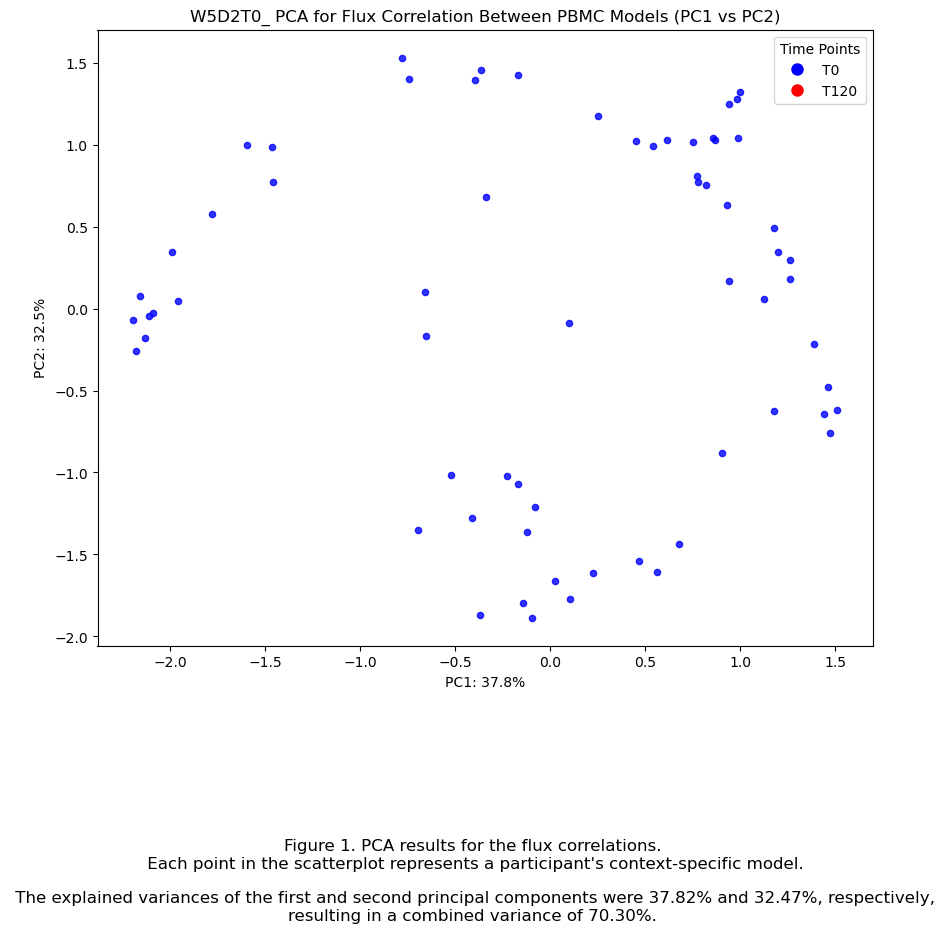

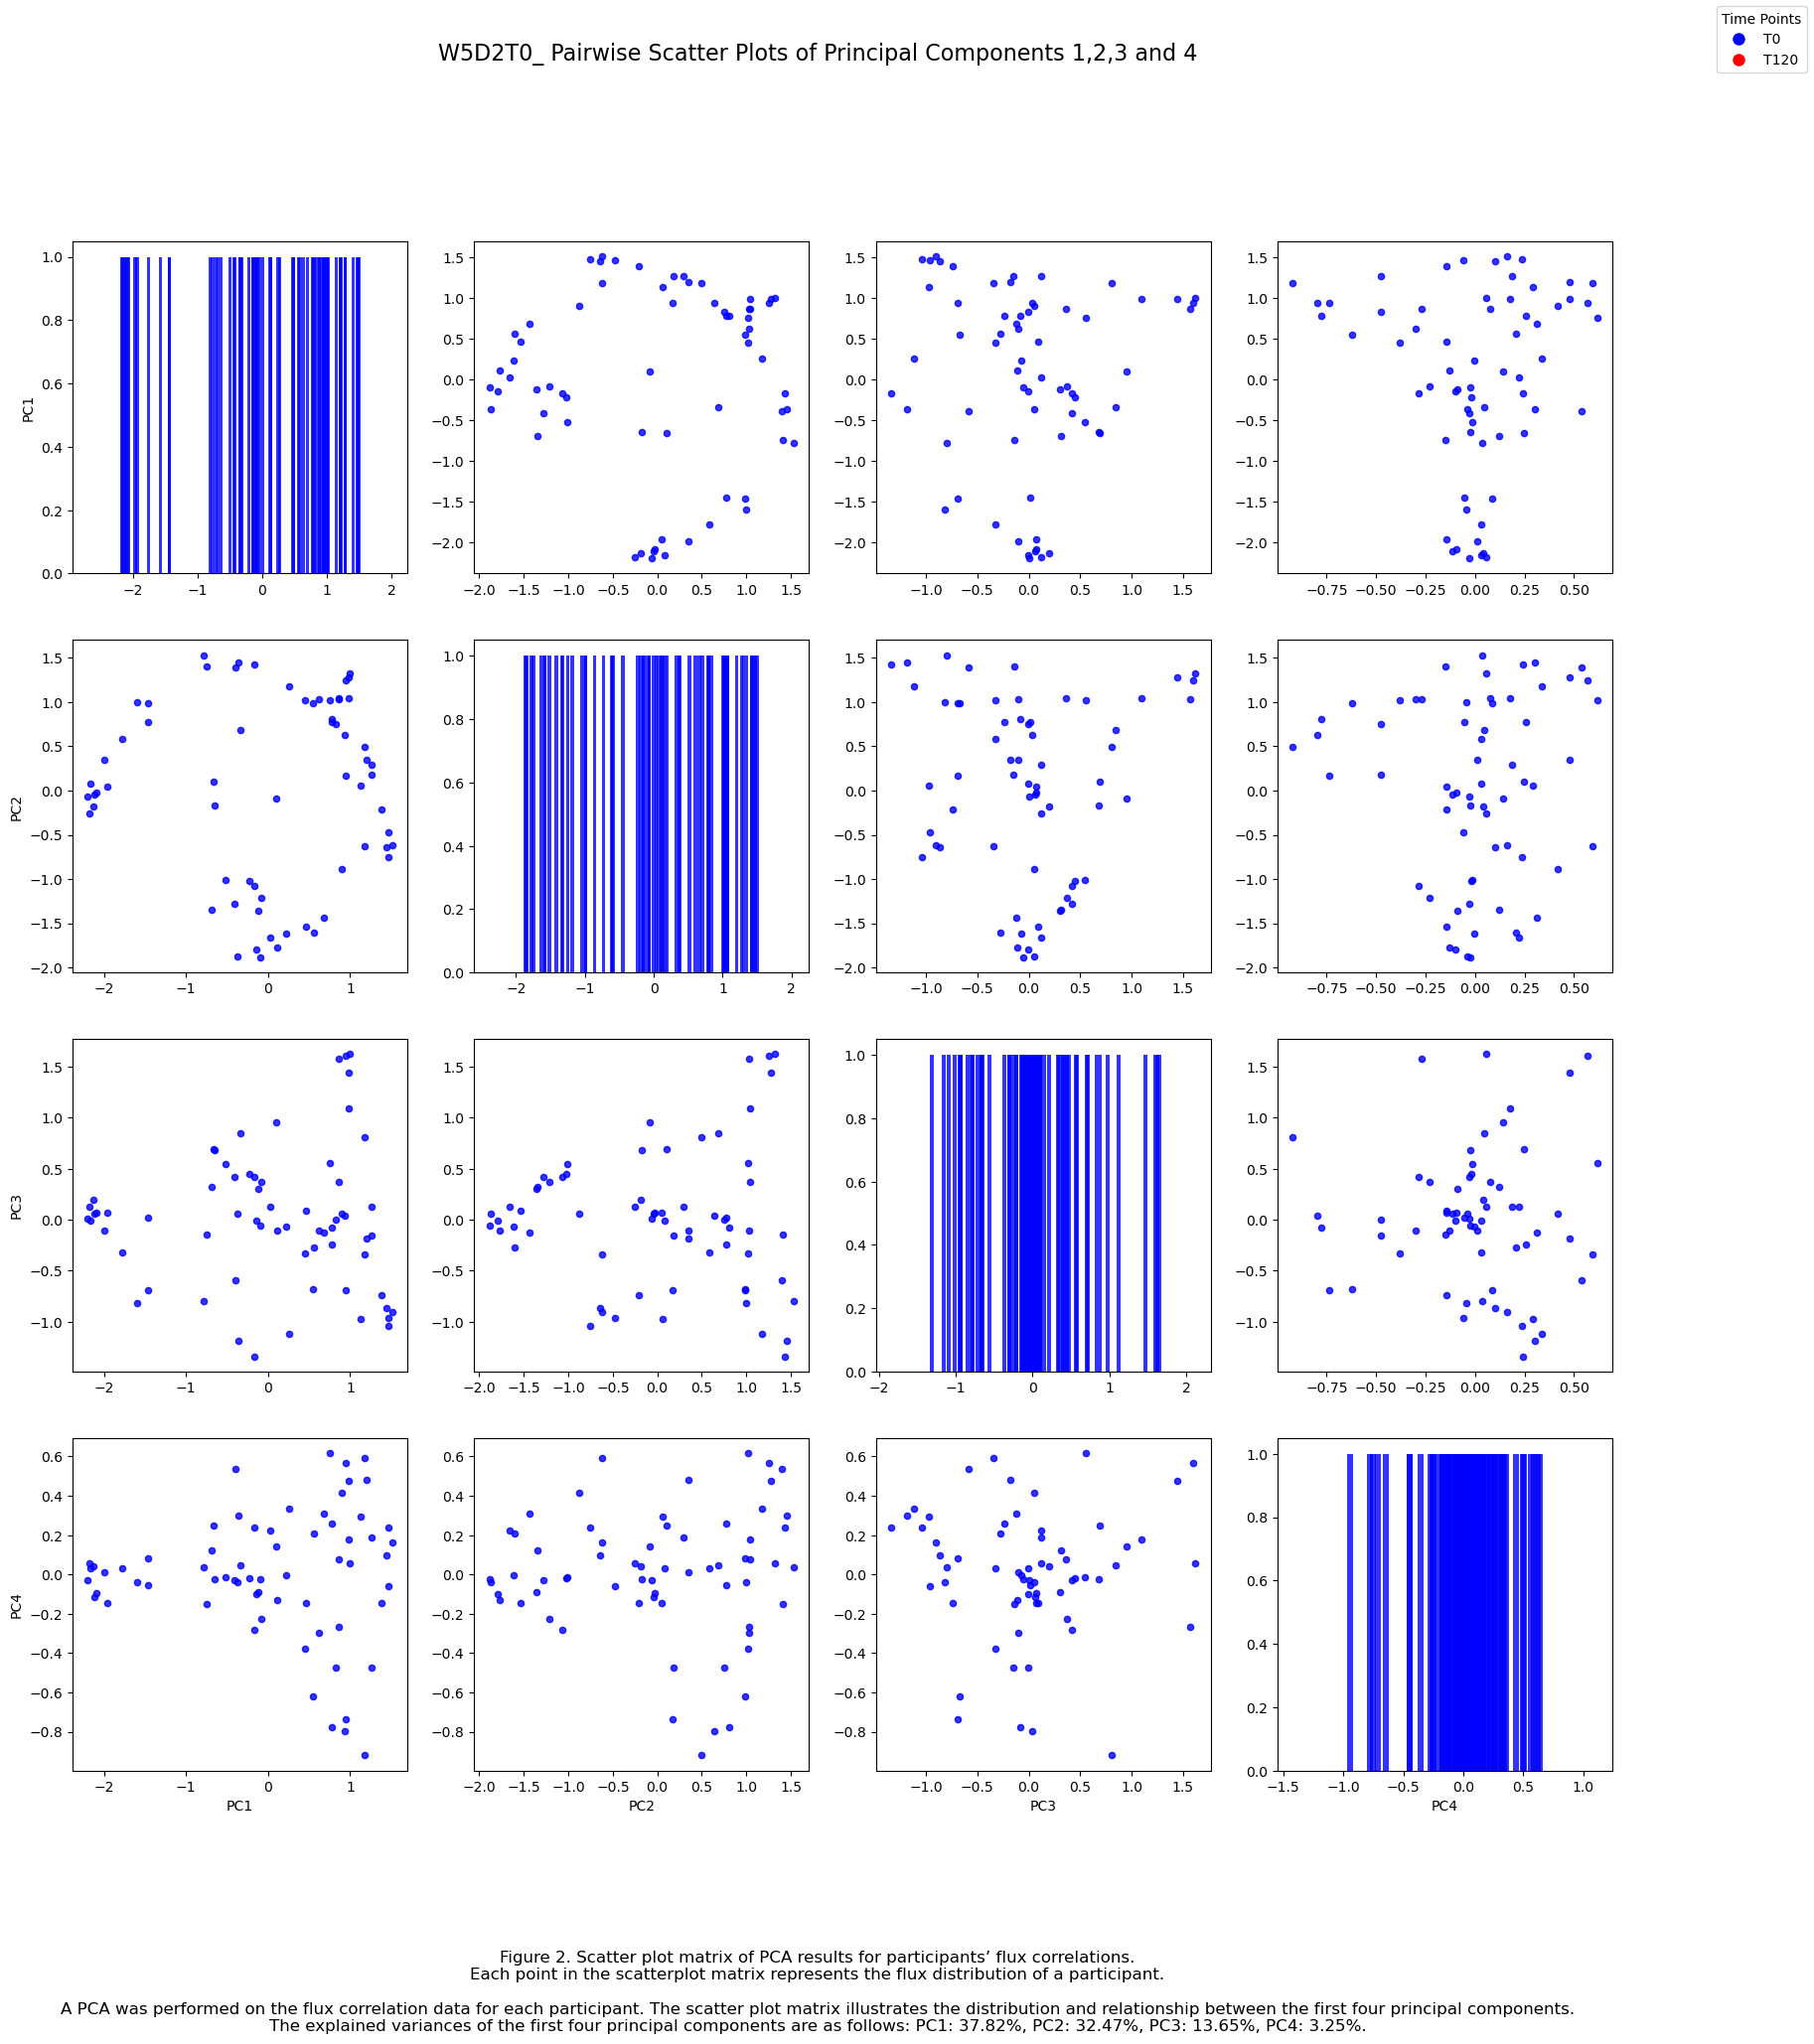

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx1.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D2T0_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D2T120, code from docs, FBA = true

In [2]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 65 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx2 = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx2)
print(pca.explained_variance_ratio_)
```

In [3]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120
FBA...
<Solution 1000.000 at 0x1ac7d4390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120
FBA...
<Solution 1000.000 at 0x1addf8c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT078_W5D2T120
FBA...
<Solution 1000.000 at 0x1af36b850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT009_W5D2T120
FBA...
<Solution 1000.000 at 0x1b0a6ad90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT008_W5D2T120
FBA...
<Solution 1000.000 at 0x1b2208a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT010_W5D2T120
FBA...
<Solution 1000.000 at 0x1b39986d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT045_W5D2T120
FBA...
<Solution 1000.000 at 0x1b4f96850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT132_W5D2T120
FBA...
<Solution 1000.000 at 0x1b671d9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT017_W5D2T120
FBA...
<Solution 1000.000 at 0x1b7e1a190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT120_W5D2T120
FBA...
<Solution 1000.000 at 0x1ad4f30d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT002_W5D2T120
FBA...
<Solution 1000.000 at 0x1b2128550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT057_W5D2T120
FBA...
<Solution 1000.000 at 0x1b1b27350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT066_W5D2T120
FBA...
<Solution 1000.000 at 0x1b2810910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT143_W5D2T120
FBA...
<Solution 1000.000 at 0x1b1325ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT034_W5D2T120
FBA...
<Solution 1000.000 at 0x1b933f450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT021_W5D2T120
FBA...
<Solution 1000.000 at 0x1bac7a450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT103_W5D2T120
FBA...
<Solution 1000.000 at 0x1bc26a4d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT104_W5D2T120
FBA...
<Solution 1000.000 at 0x1b27f9790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT151_W5D2T120
FBA...
<Solution 1000.000 at 0x1ad108e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT051_W5D2T120
FBA...
<Solution 1000.000 at 0x1abcfaad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT056_W5D2T120
FBA...
<Solution 1000.000 at 0x1b7dd8090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT043_W5D2T120
FBA...
<Solution 1000.000 at 0x1b1178090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT133_W5D2T120
FBA...
<Solution 1000.000 at 0x1bd8f3450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT044_W5D2T120
FBA...
<Solution 1000.000 at 0x1be1d2810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT150_W5D2T120
FBA...
<Solution 1000.000 at 0x1c06af850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT027_W5D2T120
FBA...
<Solution 1000.000 at 0x1be4177d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT020_W5D2T120
FBA...
<Solution 1000.000 at 0x1b14d79d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT035_W5D2T120
FBA...
<Solution 1000.000 at 0x1bb801c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT142_W5D2T120
FBA...
<Solution 1000.000 at 0x1ba153f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT067_W5D2T120
FBA...
<Solution 1000.000 at 0x1b5673ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT032_W5D2T120
FBA...
<Solution 1000.000 at 0x1bc9b0d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT145_W5D2T120
FBA...
<Solution 1000.000 at 0x1c28dcd90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT123_W5D2T120
FBA...
<Solution 1000.000 at 0x1c4dc7dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT001_W5D2T120
FBA...
<Solution 1000.000 at 0x1c6596ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT006_W5D2T120
FBA...
<Solution 1000.000 at 0x1b9cee610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT013_W5D2T120
FBA...
<Solution 1000.000 at 0x1b8547f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT131_W5D2T120
FBA...
<Solution 1000.000 at 0x1bf92d0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT041_W5D2T120
FBA...
<Solution 1000.000 at 0x1bd95ed90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT077_W5D2T120
FBA...
<Solution 1000.000 at 0x1bd73b5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT025_W5D2T120
FBA...
<Solution 1000.000 at 0x1c263f090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT070_W5D2T120
FBA...
<Solution 1000.000 at 0x1c80c7410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT152_W5D2T120
FBA...
<Solution 1000.000 at 0x1c9856450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT147_W5D2T120
FBA...
<Solution 1000.000 at 0x1cafd3490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT065_W5D2T120
FBA...
<Solution 1000.000 at 0x1bea33310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT140_W5D2T120
FBA...
<Solution 1000.000 at 0x1b55f6d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT137_W5D2T120
FBA...
<Solution 1000.000 at 0x1c2f3d5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT015_W5D2T120
FBA...
<Solution 1000.000 at 0x1bb715910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT125_W5D2T120
FBA...
<Solution 1000.000 at 0x1c621fd50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT055_W5D2T120
FBA...
<Solution 1000.000 at 0x1c6d6fd50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT141_W5D2T120
FBA...
<Solution 1000.000 at 0x1ccb73810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT114_W5D2T120
FBA...
<Solution 1000.000 at 0x1ce29c650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT064_W5D2T120
FBA...
<Solution 1000.000 at 0x1cfa36590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT031_W5D2T120
FBA...
<Solution 1000.000 at 0x1c1e8f210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT146_W5D2T120
FBA...
<Solution 1000.000 at 0x1bef08590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT106_W5D2T120
FBA...
<Solution 1000.000 at 0x1bc164690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT076_W5D2T120
FBA...
<Solution 1000.000 at 0x1cc078050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT023_W5D2T120
FBA...
<Solution 1000.000 at 0x1ca2ea790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT089_W5D2T120
FBA...
<Solution 1000.000 at 0x1ca5e5850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT084_W5D2T120
FBA...
<Solution 1000.000 at 0x1d1674850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT018_W5D2T120
FBA...
<Solution 1000.000 at 0x1d2c6d150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT090_W5D2T120
FBA...
<Solution 950.000 at 0x1d43bd350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT118_W5D2T120
FBA...
<Solution 1000.000 at 0x1d5c413d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT082_W5D2T120
FBA...
<Solution 1000.000 at 0x1bffbb210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT059_W5D2T120
FBA...
<Solution 1000.000 at 0x1c1815890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT129_W5D2T120
FBA...
<Solution 1000.000 at 0x1b4a84b10>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [4]:
reactions_matrix
reactions_matrix.to_csv('rxns_W5D2T120_.csv', index=True)

In [5]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [6]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [7]:
flx_df
flx_df.to_csv('flx_df_W5D2T120_.csv', index=True)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [8]:
#%% Perform flux correlation between pairs of models
pw_flx2 = flux_DM(flx_df)
pw_flx2
# Save pw_flx1 as a CSV file
pw_flx2.to_csv('W5D2T120_.csv', index=True)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.54239113 0.16269086 0.09566434]


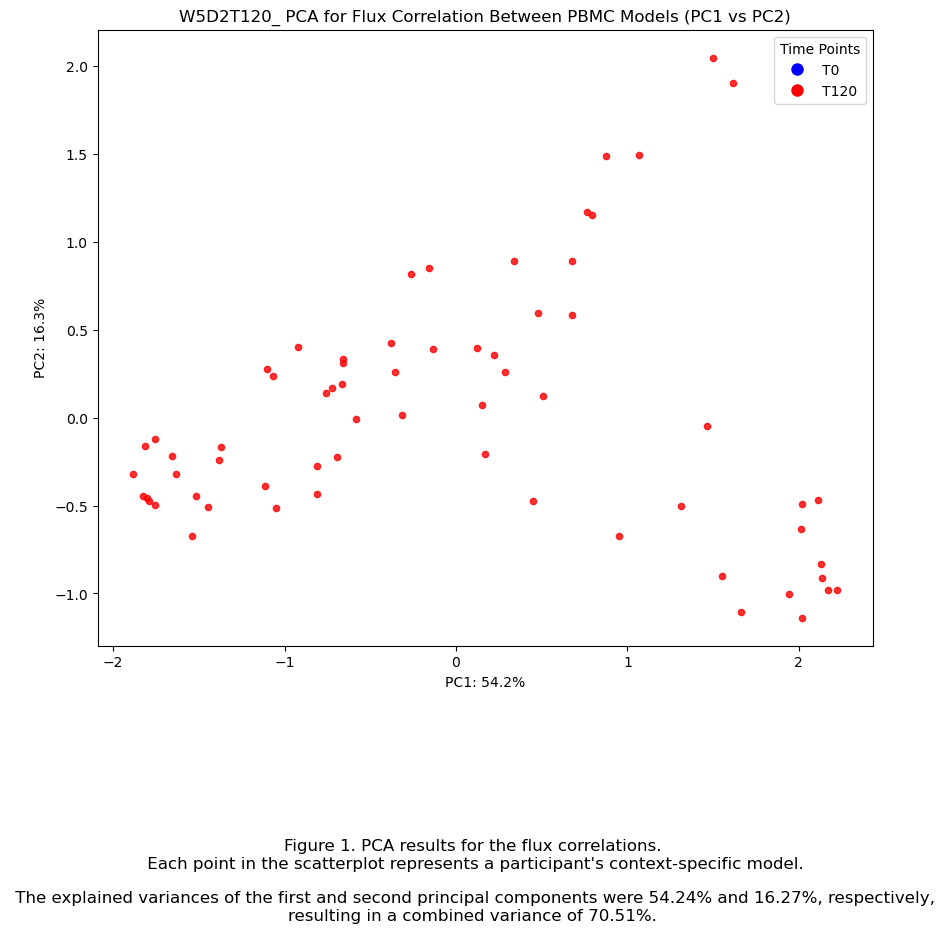

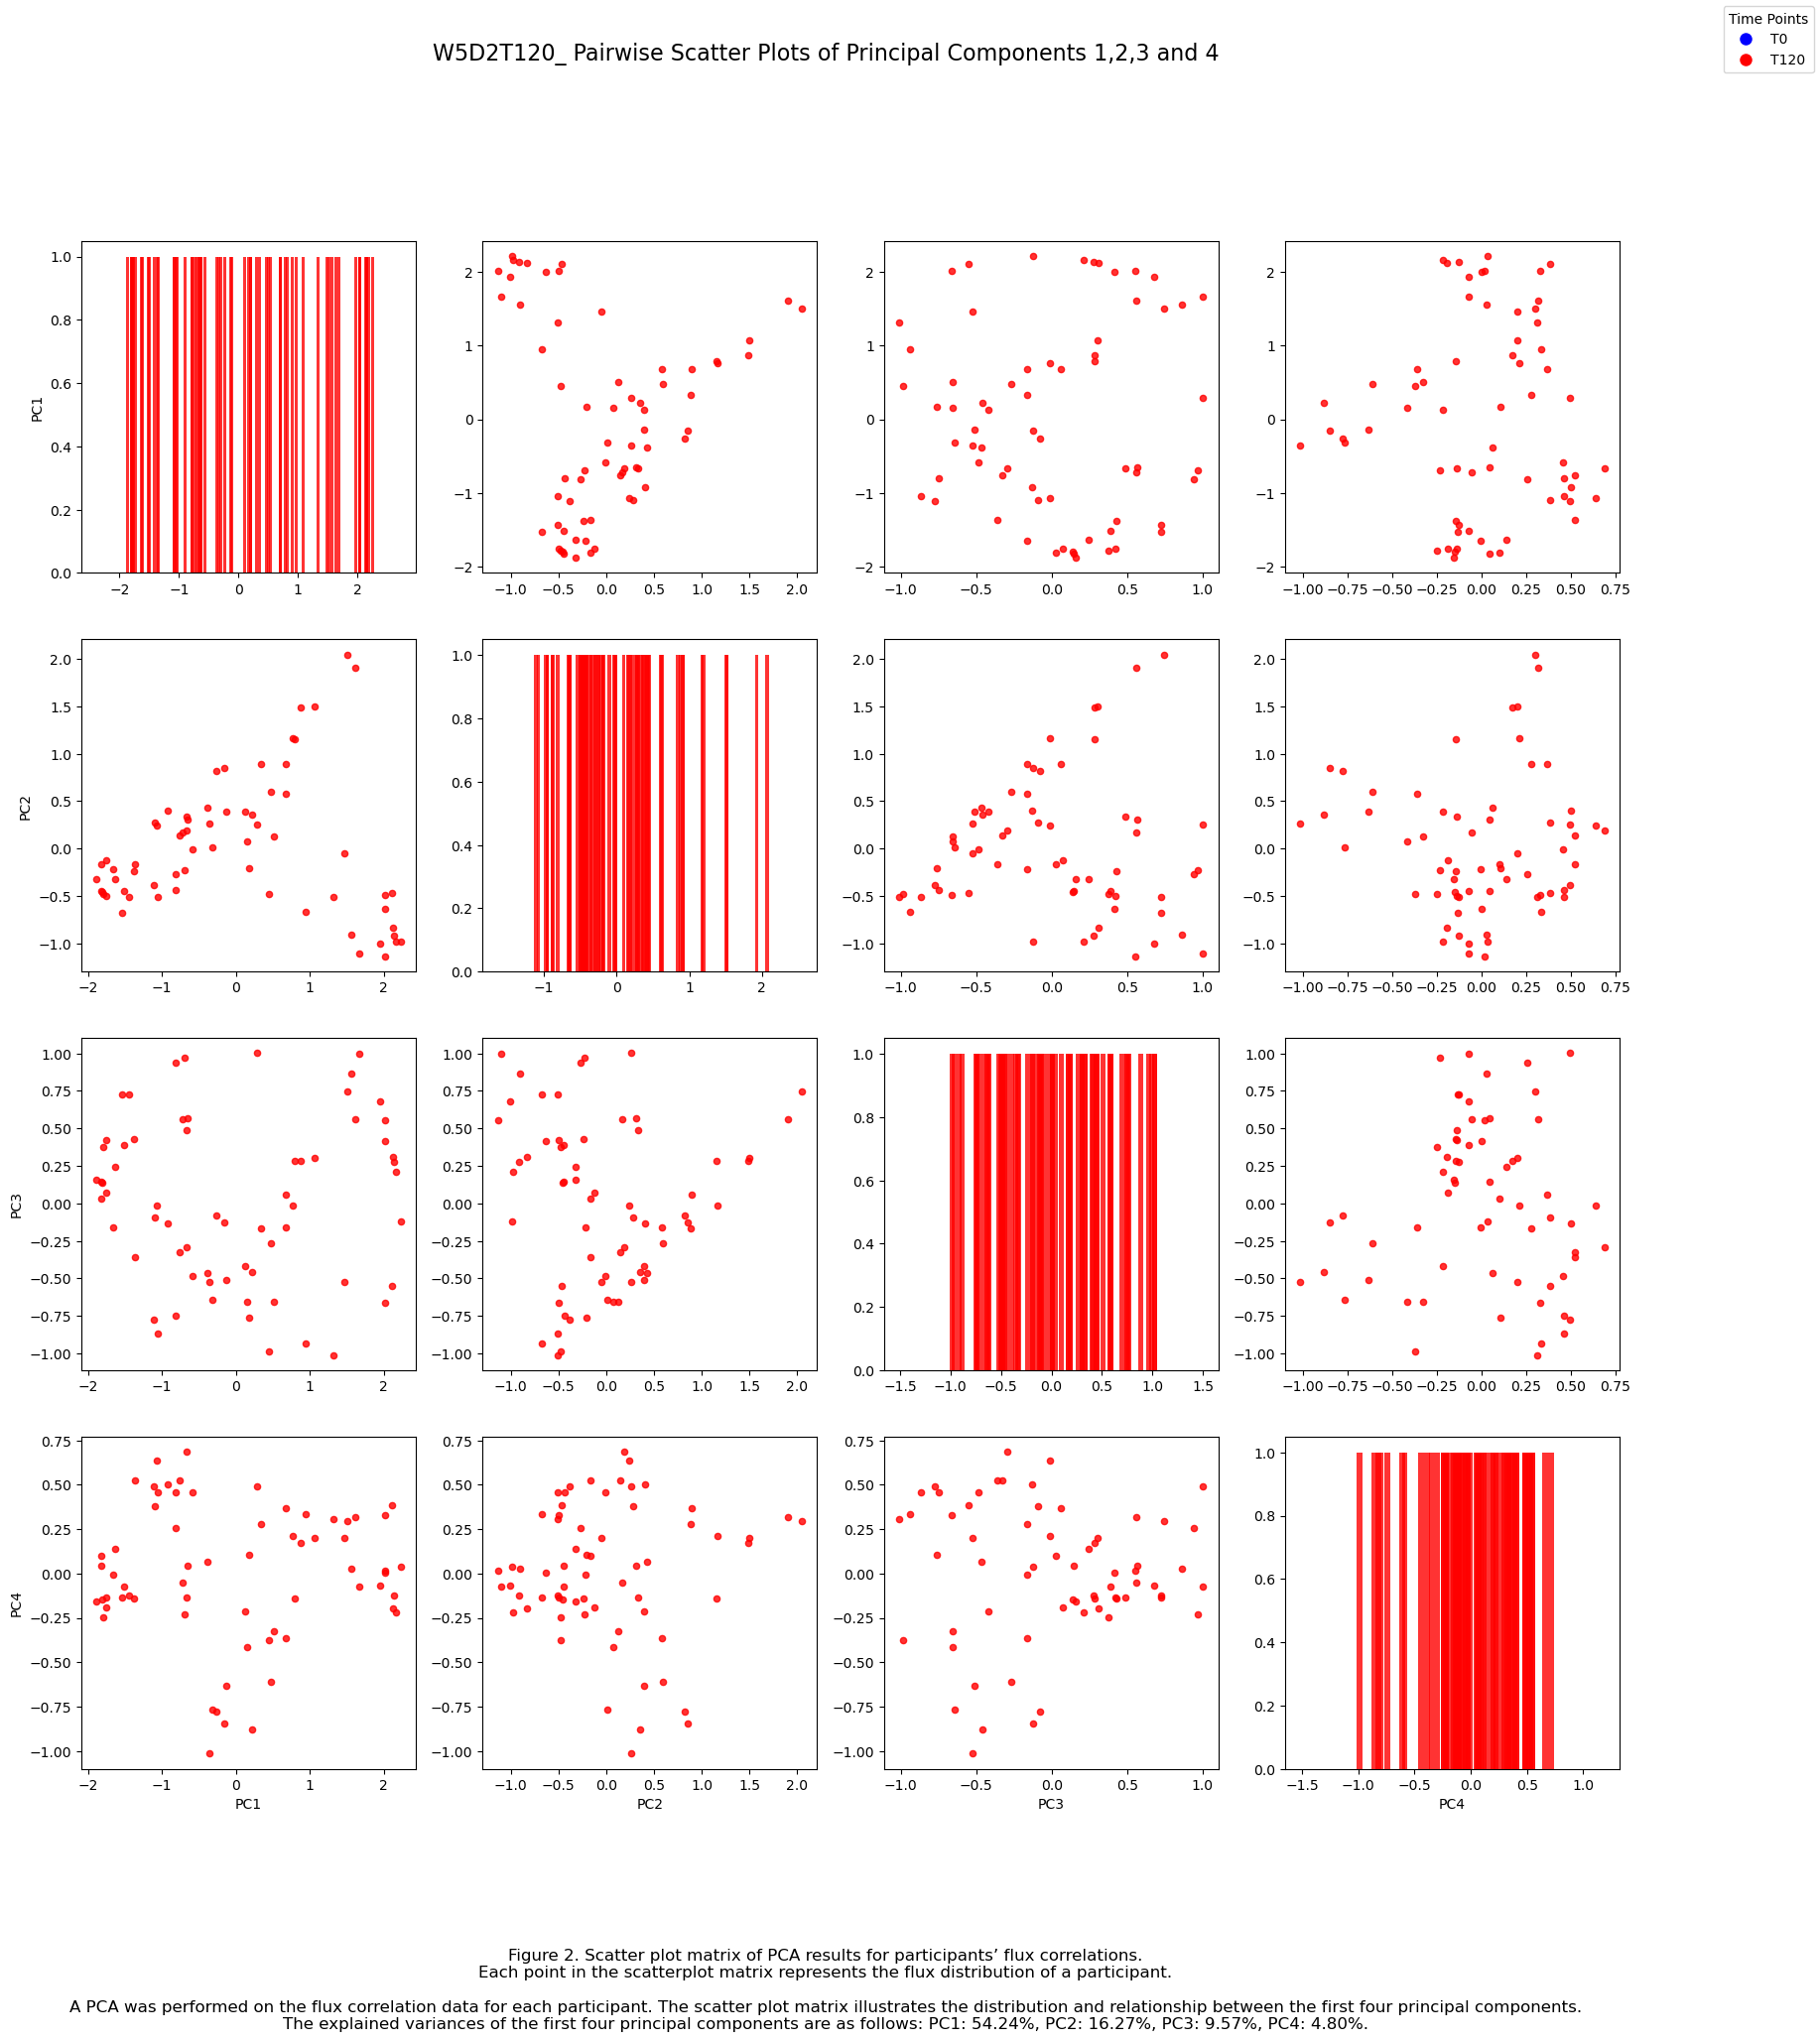

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D2T120_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T0, code from docs, FBA = true

In [9]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [10]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x18402bb90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x18564b890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x187242010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x18952c710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x18af98110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x18cb8a590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x17f5a3c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x1881b8710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x1a9487490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x1a7b9bb50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x18382bc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x17c77e4d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x18de02c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x18fc31890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x1919d14d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x1a9069610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x18337ced0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x18ec2b9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x18959fe90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x18bea1090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x1a8a6e850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x193909a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x19524f810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x196b4a550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x1943415d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x18d2b7890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x186fd2310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x185ed1ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x18eded590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x190b63910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x19a64a1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x19cdf47d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x1a01b6e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x1dcb1f0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x199c0a7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x186b08250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x18c202990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x194b81fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x19def0710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x194fff490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x19dbff410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x1df35d650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x1e07d6c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x1e1ec8bd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x1969419d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x189472a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x190f8a810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x19e8ba390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x19978db50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x1de90a390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x1e2aeed50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x1e413dc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT143_W5D3T0
FBA...
<Solution 1000.000 at 0x1e58c69d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT152_W5D3T0
FBA...
<Solution 1000.000 at 0x1e6f67990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT046_W5D3T0
FBA...
<Solution 1000.000 at 0x1e867ef90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT013_W5D3T0
FBA...
<Solution 1000.000 at 0x1dd4cd750>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                    

In [11]:
reactions_matrix
reactions_matrix.to_csv('rxns_W5D3T0_.csv', index=True)

In [12]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                            

In [13]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_A

In [14]:
flx_df
flx_df.to_csv('flx_df_W5D3T0_.csv', index=True)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [15]:
#%% Perform flux correlation between pairs of models
pw_flx2_1 = flux_DM(flx_df)
pw_flx2_1
# Save pw_flx1 as a CSV file
pw_flx2_1.to_csv('W5D3T0_.csv', index=True)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.36762544 0.25403733 0.08680735]


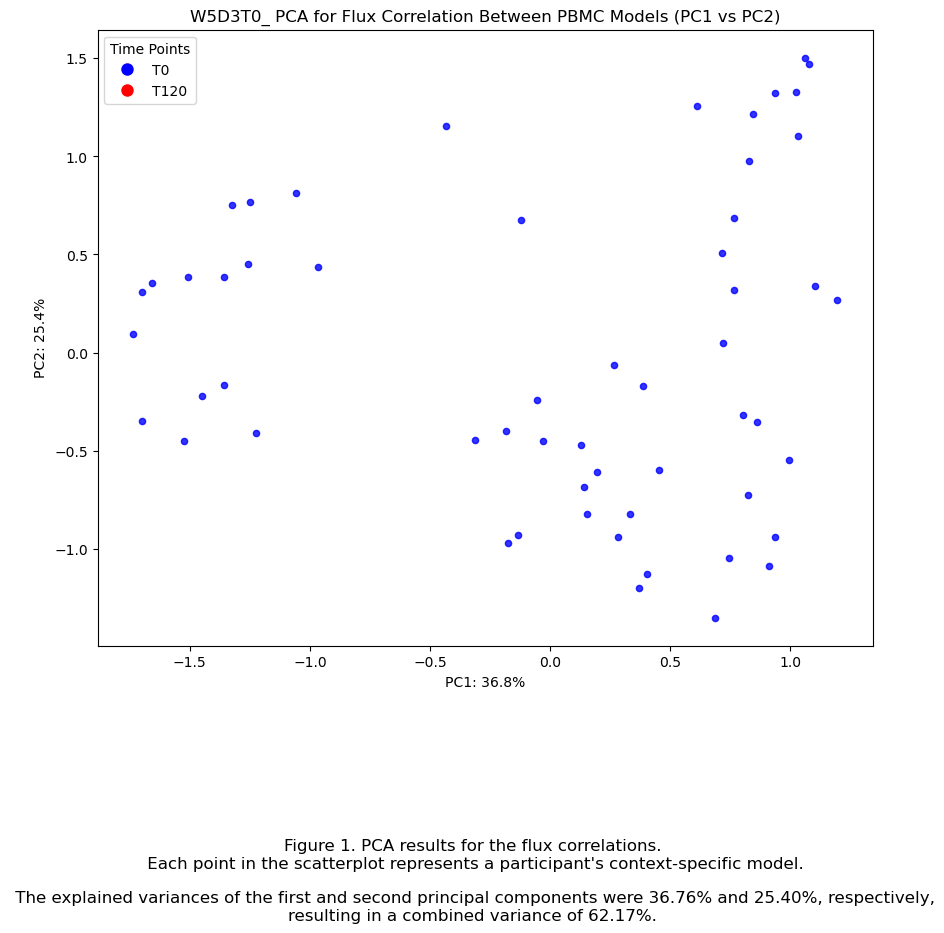

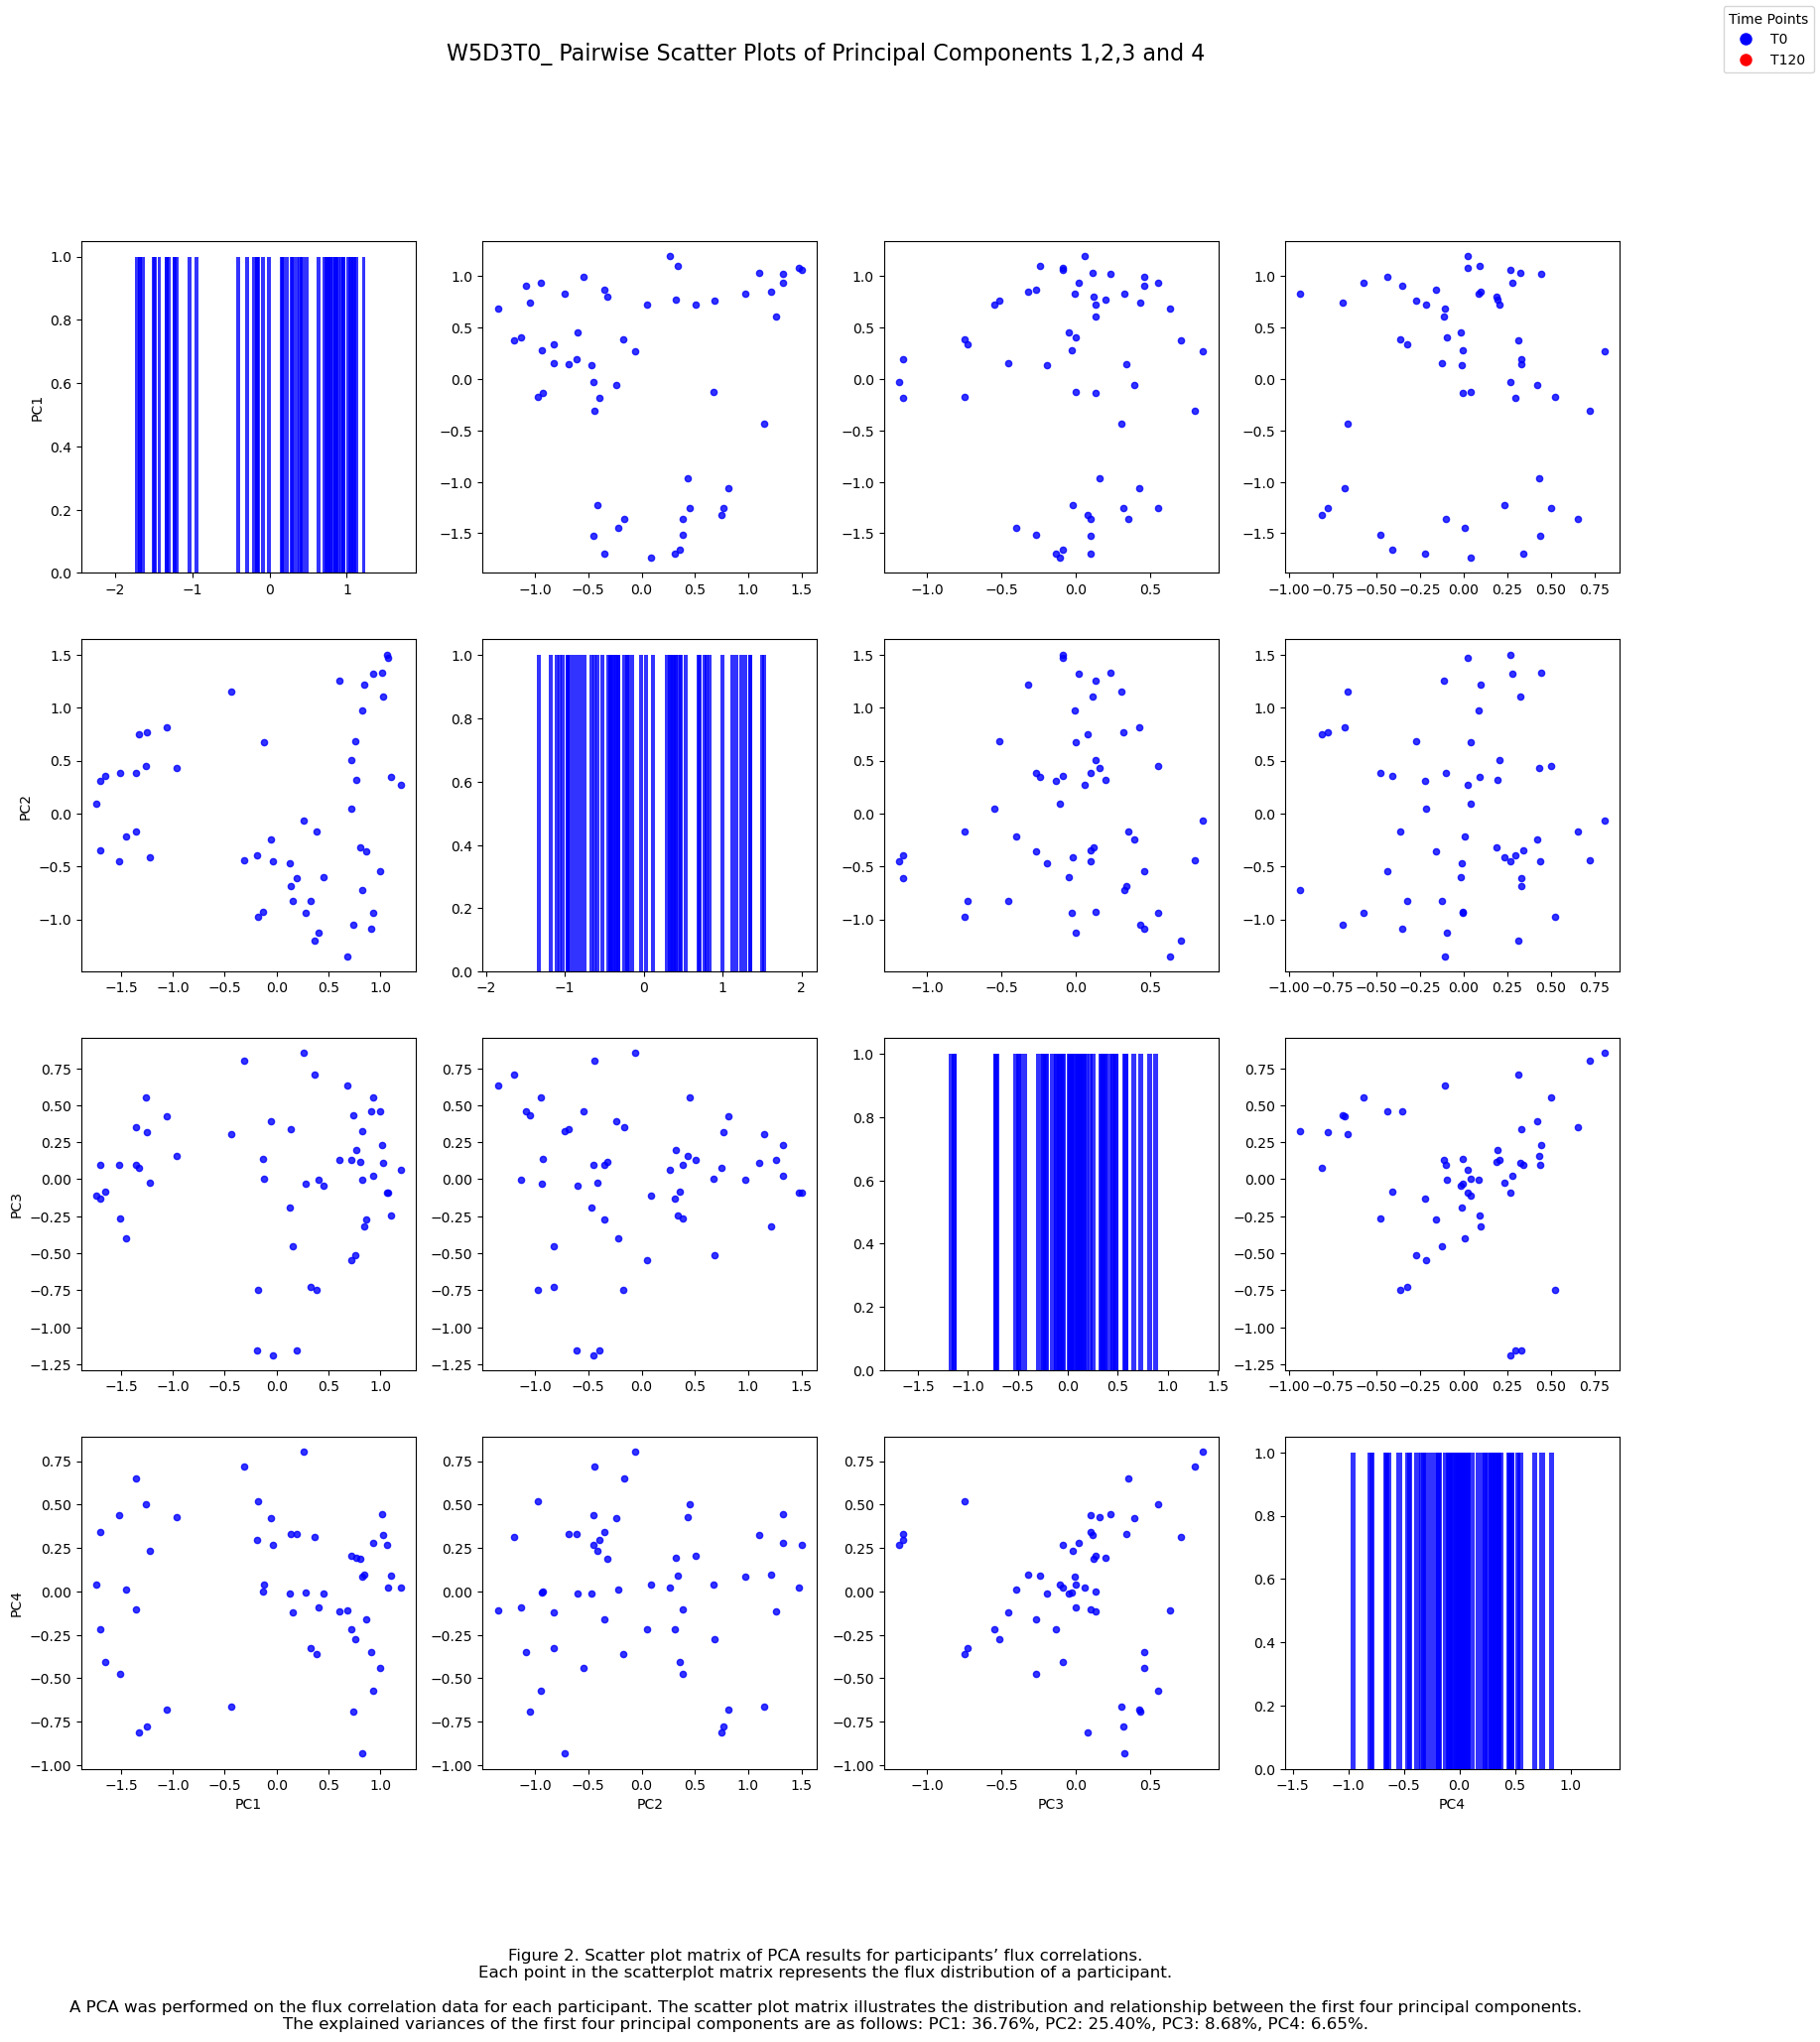

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_1.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T0_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T120, code from docs, FBA = true

In [16]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [17]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x16a2b2410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x16c000490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x16fb503d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x1730adb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1d6121d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x16848cf10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x16d9729d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x1680db910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x16cc16e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x182c2b0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x16cccee10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x1d816a490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x1d9a860d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x1db280950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x1ef197b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x1f0815810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x182989190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x16307d010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x177e824d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x170d64e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x1d8e1a090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x1d6d22c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x1d89fc890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x1f1297450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x1f36f2110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x1f4dc53d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x1f6451610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x1d8befcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x1d72be0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x17204e710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x1daf67e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x1808d2f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x1f0210690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x1f0f392d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x1f7abb610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x1f92ec750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x1faadcbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x1fc129510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1fd706f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x1f41074d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x1d7936cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x1d748f050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x1d778cf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x175318510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x1f60a1b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x1f82efcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x1fef30490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x2005ffd90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x201c66950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x203282950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x2048e99d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x1f4816850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x1f323e3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x1d9753690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x1f8827dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x1f8513d10>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [18]:
reactions_matrix
reactions_matrix.to_csv('rxns_W5D3T120_.csv', index=True)

In [19]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [20]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [21]:
flx_df
flx_df.to_csv('flx_df_W5D3T120_.csv', index=True)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [22]:
#%% Perform flux correlation between pairs of models
pw_flx2_2 = flux_DM(flx_df)
pw_flx2_2
# Save pw_flx1 as a CSV file
pw_flx2_2.to_csv('W5D3T120_.csv', index=True)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.378123   0.19748016]


Text(0, 0.5, 'PC2: 9%')

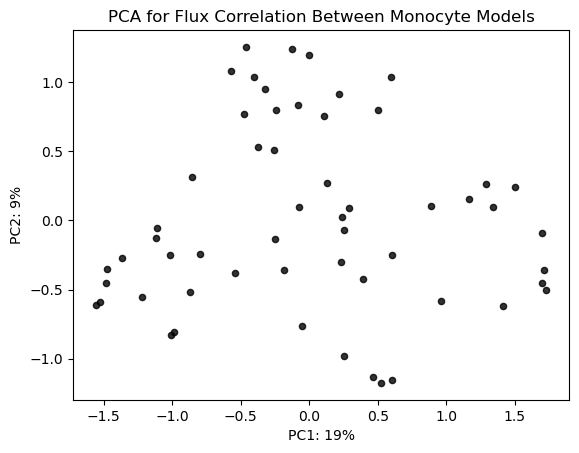

In [52]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Load pw_flx1 from the CSV file
#pw_flx2_2 = pd.read_csv('pw_flx2_2.csv')

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx2_2)
print(pca.explained_variance_ratio_)

title_font = {
'weight' : 'medium',
'size'   : 12,
}

axis_font = {
'weight' : 'normal',
'size'   : 10,
}

fig, axes = plt.subplots(nrows=1, ncols=1)
for i in range(56):
    xs = pcaData[i,0]
    ys = pcaData[i,1]
    clu = plt.scatter(xs, ys, s=20, marker='o', color='black', alpha=0.8)
    #plt.text(str(i + 1))
plt.title('PCA for Flux Correlation Between Monocyte Models', title_font)
plt.xlabel('PC1: 19%', axis_font)
plt.ylabel('PC2: 9%', axis_font)


[0.378123   0.19748016 0.09114667]


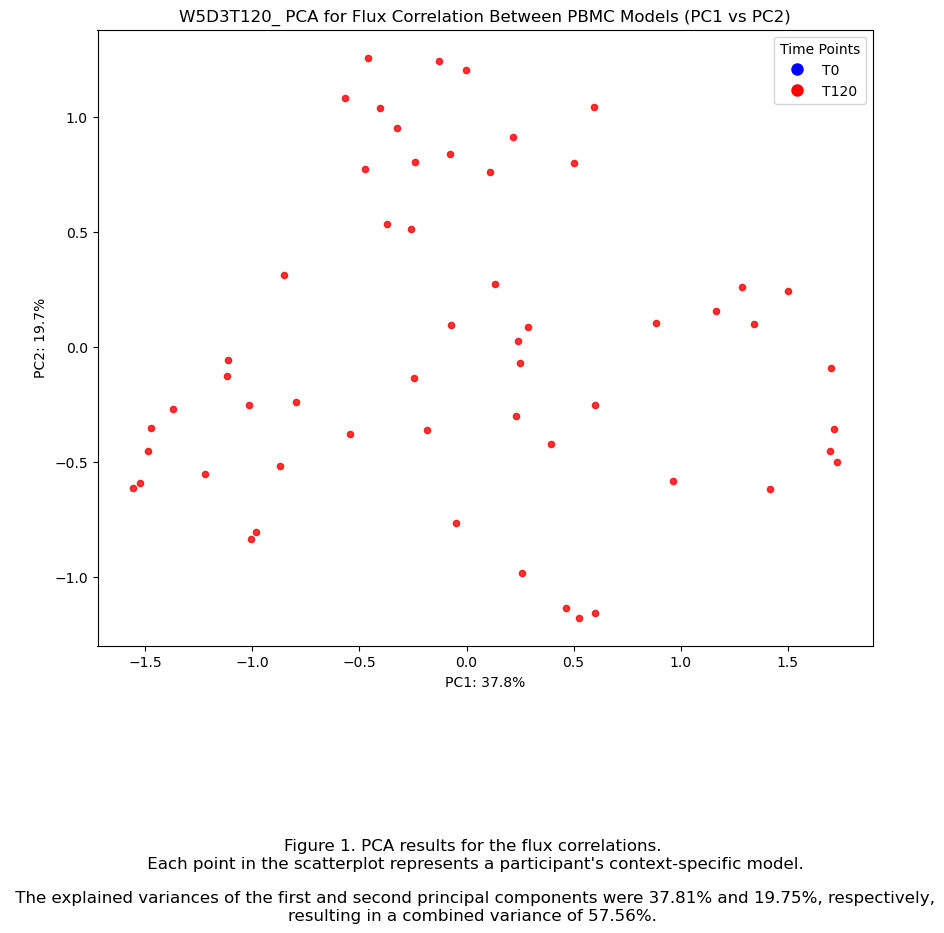

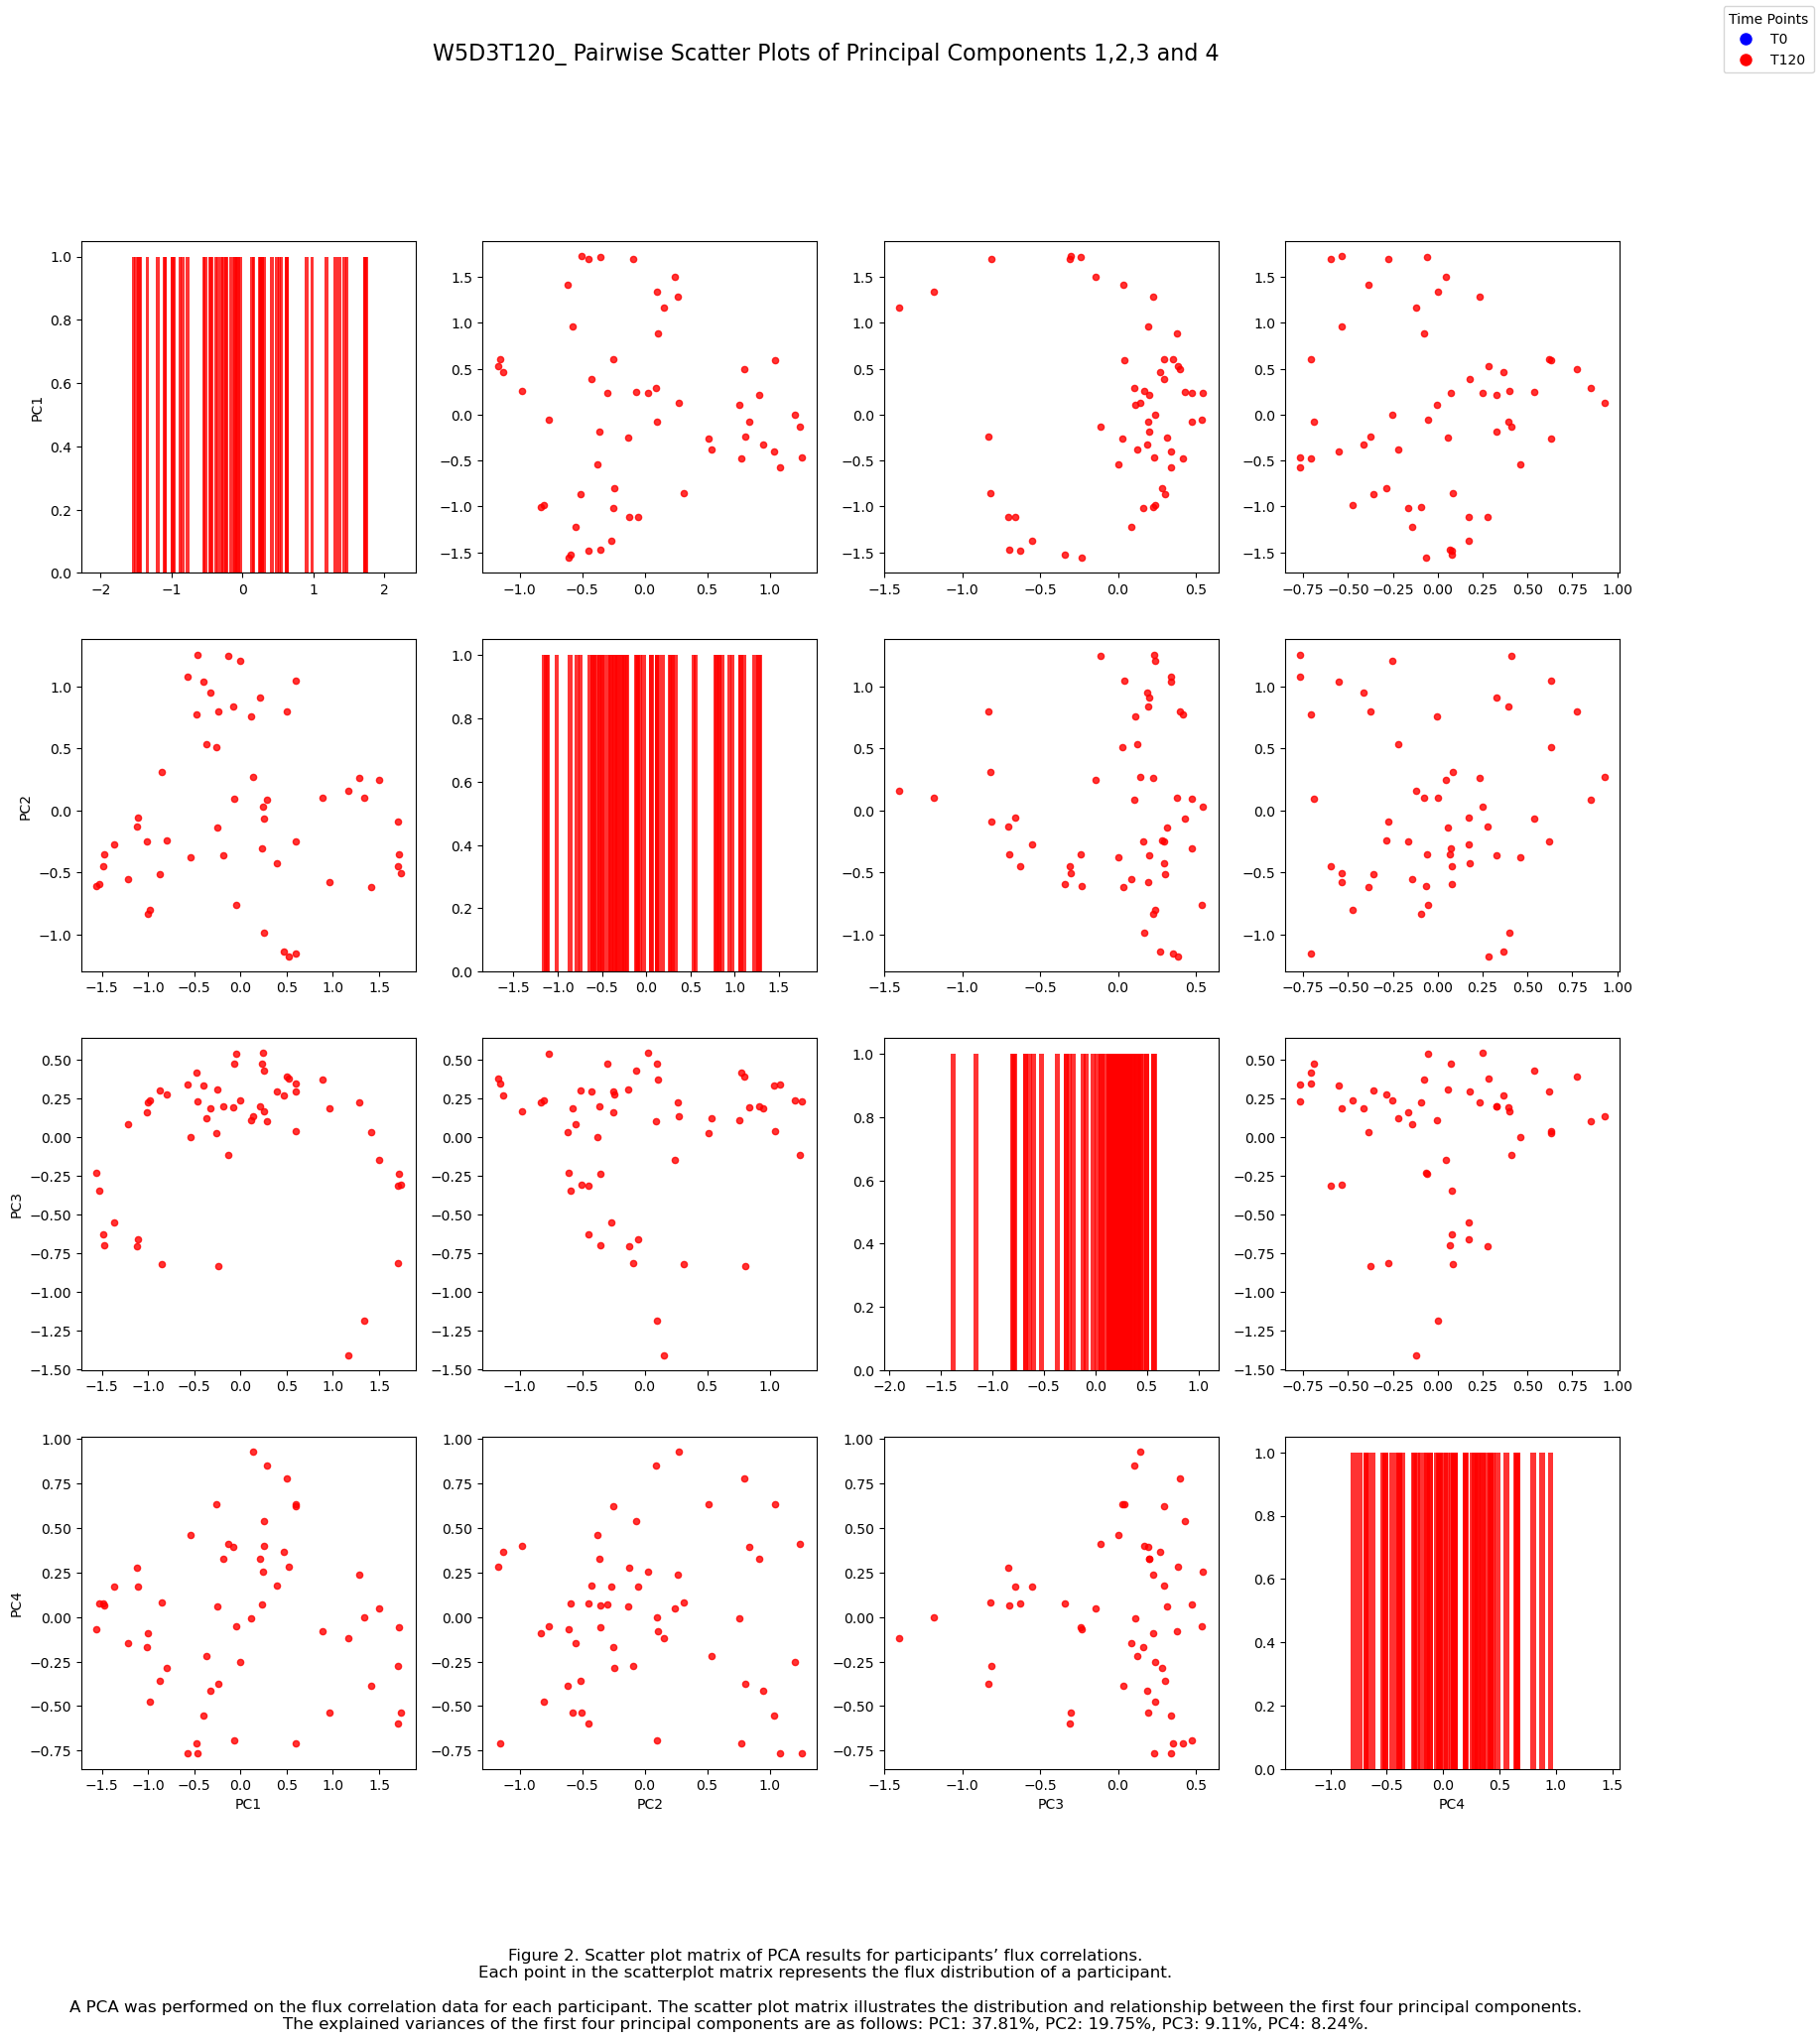

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_2.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T120_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T240, code from docs, FBA = true

In [23]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [24]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x14928b7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x14c5d0490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x1506a5b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x155f33190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x1e8e9a810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x15da4ae90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x162eba690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x16637bc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x167a85750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x14b109f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x1ea2c1a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x1eb921a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x1ed0d7910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x20b99ea90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x20d053450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x20e6ee310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x20fe7cb50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x20c34d610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x166865150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x169f62750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x1480bafd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x1ee60cf50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x1633be010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x1e94b3d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x154fce7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x1589bf710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x21298e7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x2140b8f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x215719090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x216d7fb90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x213686750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x166f89750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x14b10acd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x20f46c450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x14f7faa10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x162cf4e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x1ee0016d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x2123e47d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x2105053d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x219126190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x21881a9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x21bdde410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x21d5c6510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x21eb97ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x20c5347d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x15db37f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x2039b5610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x213a93150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x210b72710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x210523e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT118_W5D3T240
FBA...
<Solution 1000.000 at 0x213859bd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x2176ec650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x217fd3890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x220315390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x221b48850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x223159b10>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [25]:
reactions_matrix
reactions_matrix.to_csv('rxns_W5D3T240_.csv', index=True)

In [26]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [27]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [28]:
flx_df
flx_df.to_csv('flx_df_W5D3T240_.csv', index=True)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/lib/python3.11/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [ ]:
#%% Perform flux correlation between pairs of models
pw_flx2_3 = flux_DM(flx_df)
pw_flx2_3
# Save pw_flx1 as a CSV file
pw_flx2_3.to_csv('W5D3T240_.csv', index=True)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.48191545 0.23733323 0.09619983]


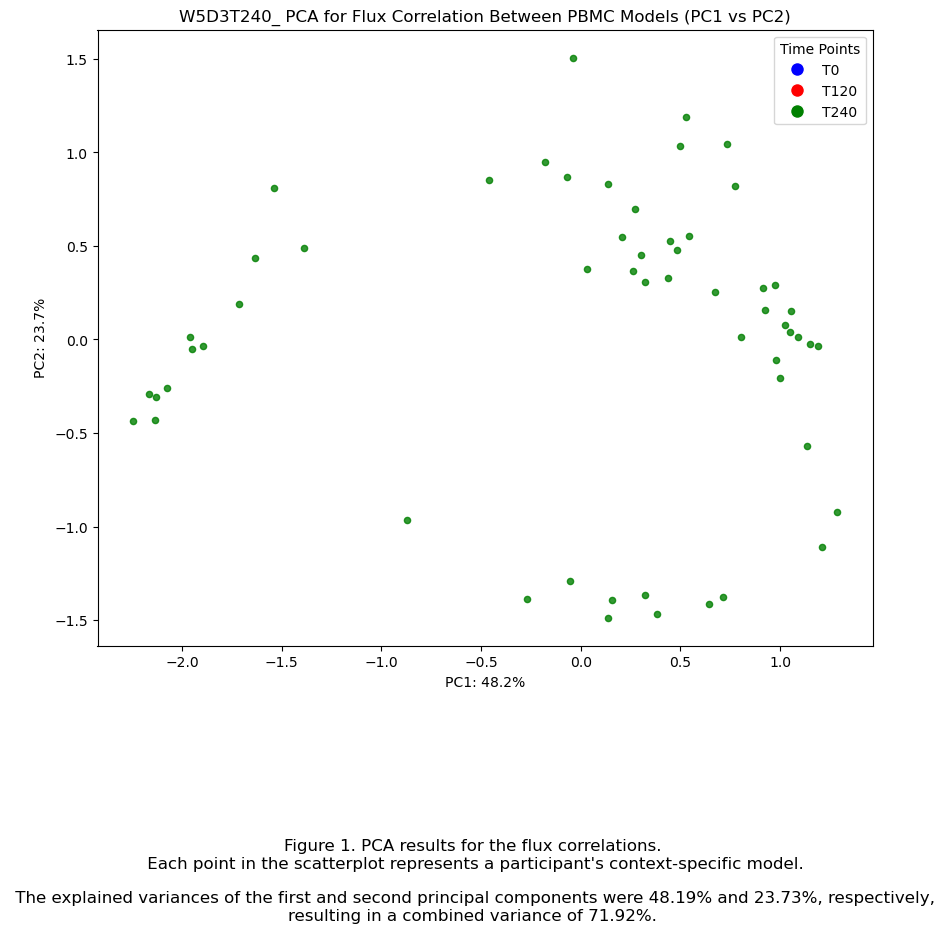

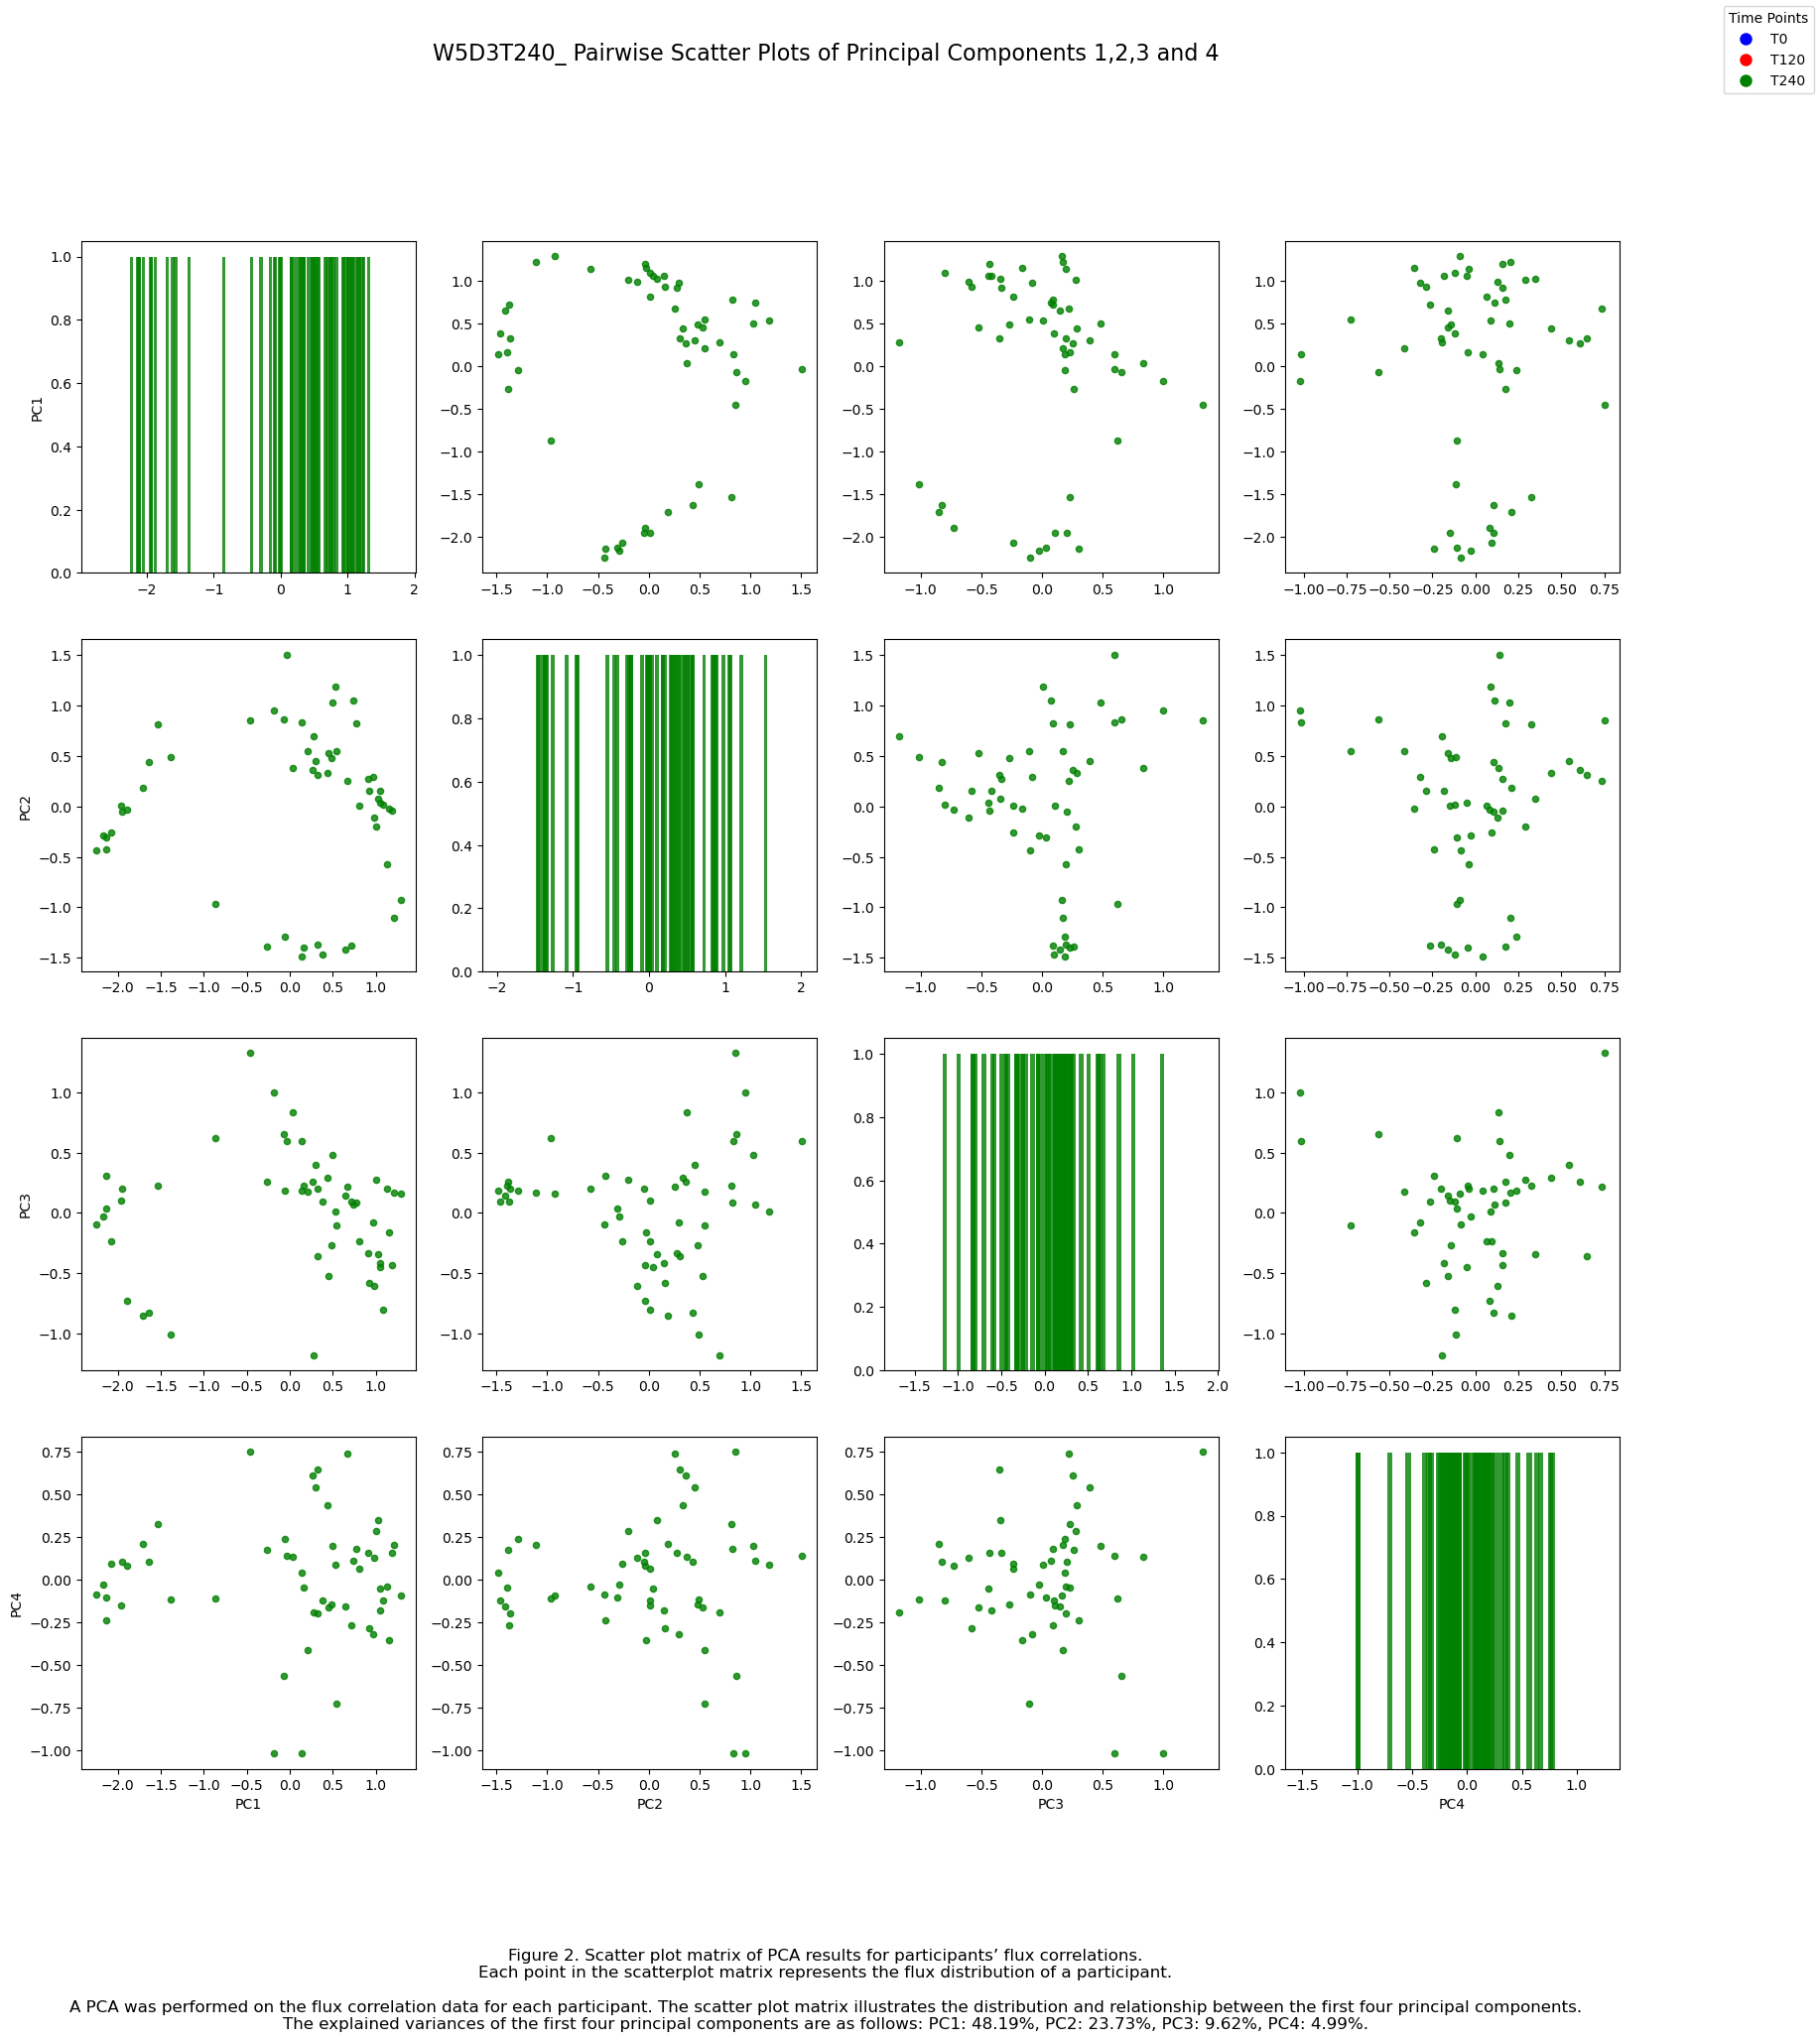

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_3.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T240_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 112 models.


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x1f52cc5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x1f69b1c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x1f7fc8b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x1f5f357d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x1f8b38310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x1fa5457d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x1fbcc8750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x1fd3e4c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x1febc1d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x2002b7890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x2018f4810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x2031c0510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x2047af1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x205d37890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x20744b9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x208d38d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x20661a9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x1fbc10050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x1f78334d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x202bd4450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x1fa084ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1fe45d050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x200ca5a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x1f705bc90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x200918c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x20b3e4a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x20bc86950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x20e1fd150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x20f82b290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x210e1fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x211629150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x1f765a810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x1f72c8b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x2095f0c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x1fb069c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x20402d790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x203d1cb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x20c6f6790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x2083c1b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x212254790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x21388f010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x214ffc690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x21672e190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x216ffbfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x2158c8d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x203d1d750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x2127ec590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x1fe95a090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x1f62ae550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x20d077c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x1fdc033d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x2192ca390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x21201a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x2198262d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x21ae14490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x21c6161d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x21dcf9350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x21f2f0e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x220a89810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x20db3a510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x1ff8cd350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x212ecb690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x1fbcdd190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x21d2f1f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x20eed9750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x219287090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x21c39c290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x21758f610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x221392ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x222ad1a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x22433b8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x2258d8650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x227059d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x2286cb910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x21b965490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x2223b3350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x20c2f4f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1ffc2f350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x21ac25350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x215b3a250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x216eb57d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x228407590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x21fabc290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x229b95e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x22b30c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x22c9d2cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x22e0d9890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x22fc18090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x231121110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x216f2bad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x2023e8e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x209dc7f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x21a097190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x22761ead0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x21656fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x2287a6690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x226a7ff50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x22ea84210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x22bb1b050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x2321fcb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x2338f78d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x234ef8950>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x2365432d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x237c0b350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x2391df550>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x22b0b0610>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x22591c210>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT143_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x2169e3650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT152_W5D3T0


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

FBA...
<Solution 1000.000 at 0x21d66f110>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT046_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x22da2b590>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT013_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x20b308c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x229107010>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                   
25HVITD3t                                                          NaN                                                                                                                                                                                                                   
COAtl                                                              NaN                                                                                    

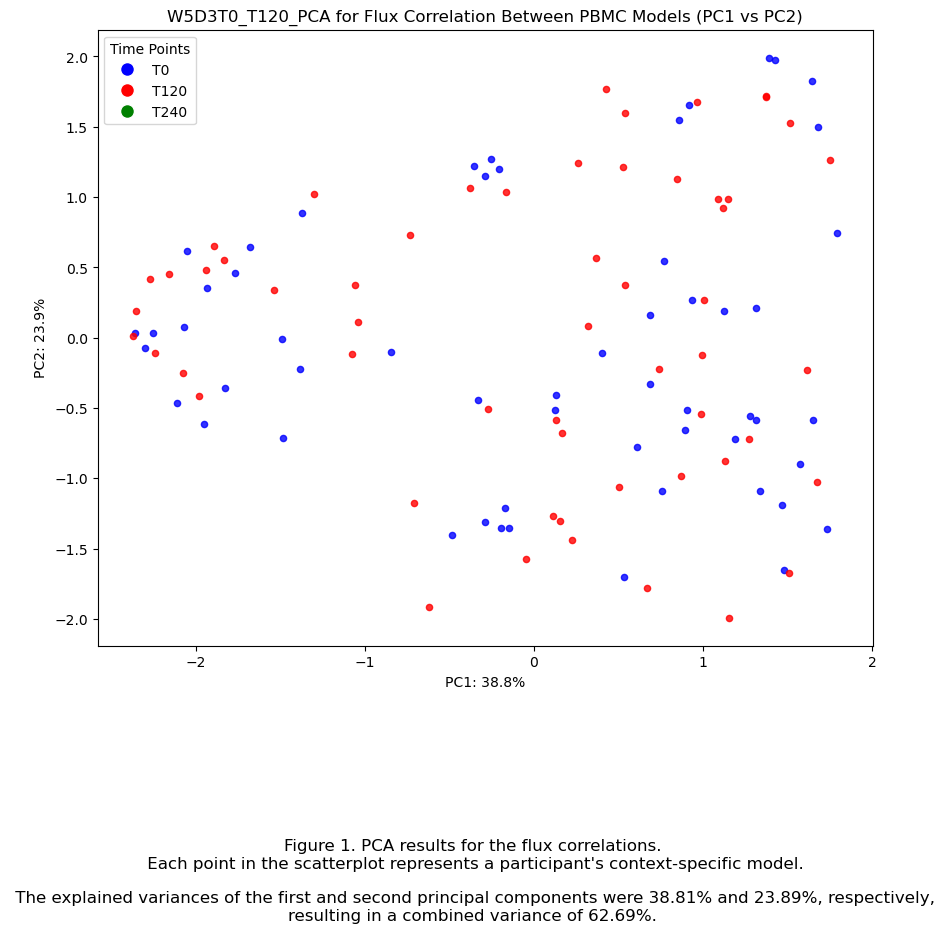

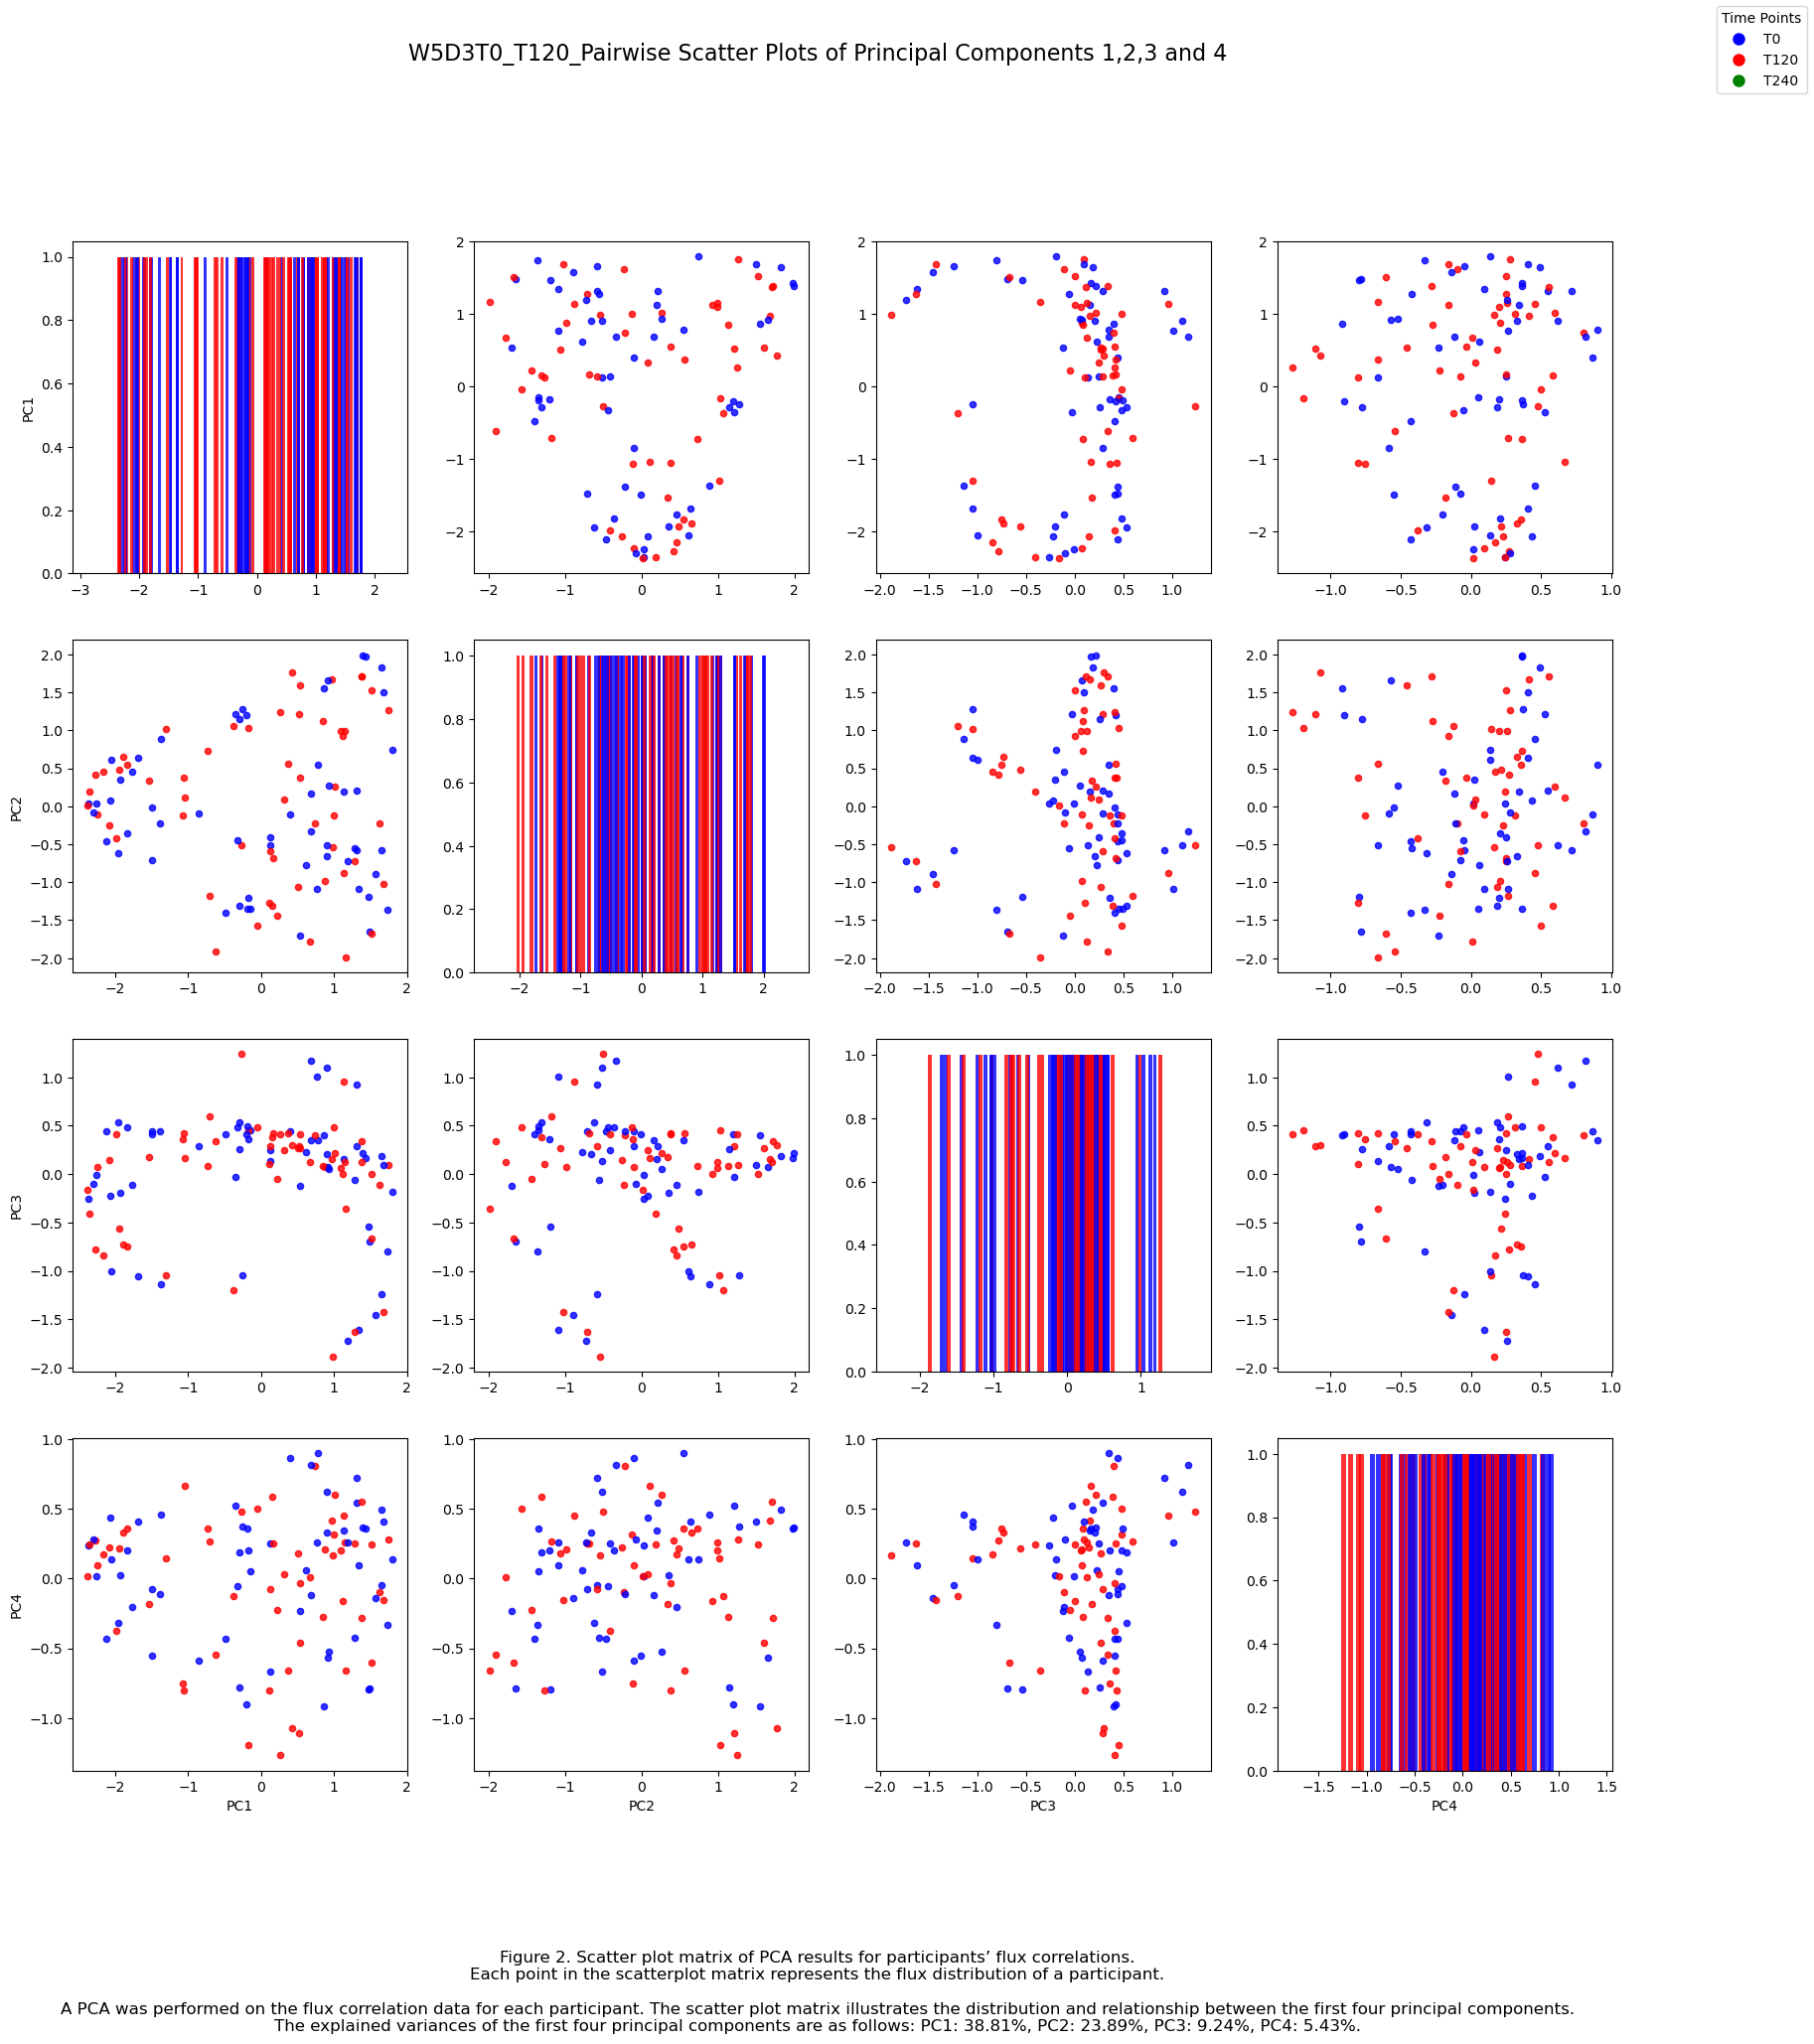

In [2]:
# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T0_T120'
flxID= 'pw_flx2_5.csv'
# %% Load the context-specific models
directory_path = f'/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/{file_ID}'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx_df)
pw_flx
# Save pw_flx1 as a CSV file
pw_flx.to_csv(f'{flxID}', index=False)

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv(f'{flxID}')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]


# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID}_PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}_fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID}_Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}_fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 112 models.


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x191400710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x1924905d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x197d0fb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x19aaedd10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x19df6a210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x1a188bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x1a62b9210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x1adda8350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1b919bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x194b853d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x1ca794290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x1cc5a1590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x1cf05ce90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x1cde7e3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x1d0c026d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x199f643d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x1b99b0610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x1c02aa3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x1c80d5b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x25c833850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x25e95ad10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x26139f0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x263018b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x26495b7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x2ab1afbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x2ac7b7050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x2adf7cbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x2af6b1910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x2b0dc9750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x2b251ff10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x25fa4fa10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x19d45b490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x1ca697250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x1a532a5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x1d163f2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x25e399c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x26583bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x1ccb84a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x1b4e0f110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x25f606190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x1d138cb50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x26392afd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x2638bfc10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x25d4c9310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x2b311b050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x2b5608f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6c95610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x2b62a2210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x2b8dc1690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x2bb2d0390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x2bc8ae990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x2bd142450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x25f14c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x19d1f9c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x1c88fa390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x181483e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x2b05b0650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x1cf14ba50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x2ad6408d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x1bf65a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x2b0d50690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x2aaeb2c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x2aefbf0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x19cb09790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x2b5cb9210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x2be8e0350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x2bffcb410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x2c17cf390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x2c2e14850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x2c45670d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x2c5d218d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x2c73a0490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x2c8c1c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x2ca244710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x2c0a72b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x198bfef90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x2ab99d150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1a35d3850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x1ce2a5d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x2bab3a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x1a8eeef10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x2bacd3050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x2c45d7a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x2c1348d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x2bf964e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x2c63f6490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x2c21198d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x2c657d050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x2c08af190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x2cbfb6710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x2cd617e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x2cedcc3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x2d052f950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x2d1d4aa90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x2d25b9510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x2d4a73590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x2d5f43910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x2cfc13110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x25dafb750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x2ba8f29d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT118_W5D3T240
FBA...
<Solution 1000.000 at 0x1a92a4f10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6b1f650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x18e746710>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x2c7de27d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x2caa6bbd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6048c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x2c9e84c90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x2d10978d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x2c7b93a10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x2ce53e350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x2c99b6950>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x2cb17cad0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                       
25HVITD3t                                                          NaN                                                                                                                                                                                                                       
COAtl                                                              NaN                                                                        

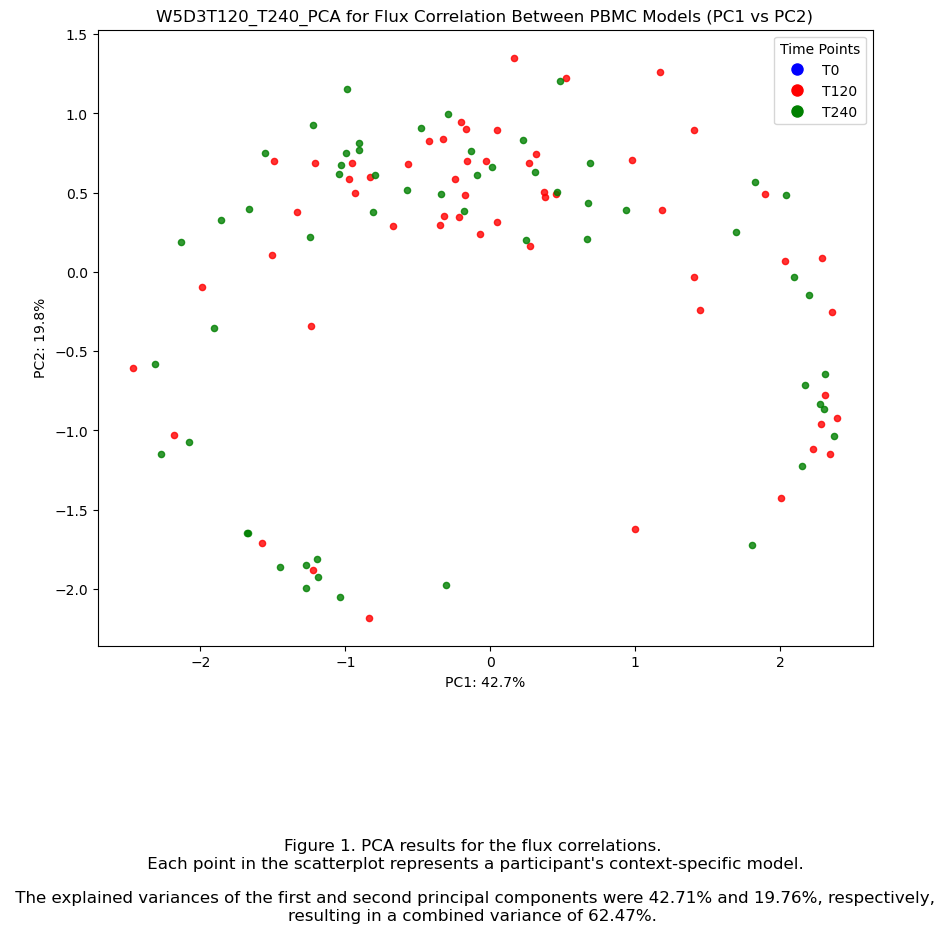

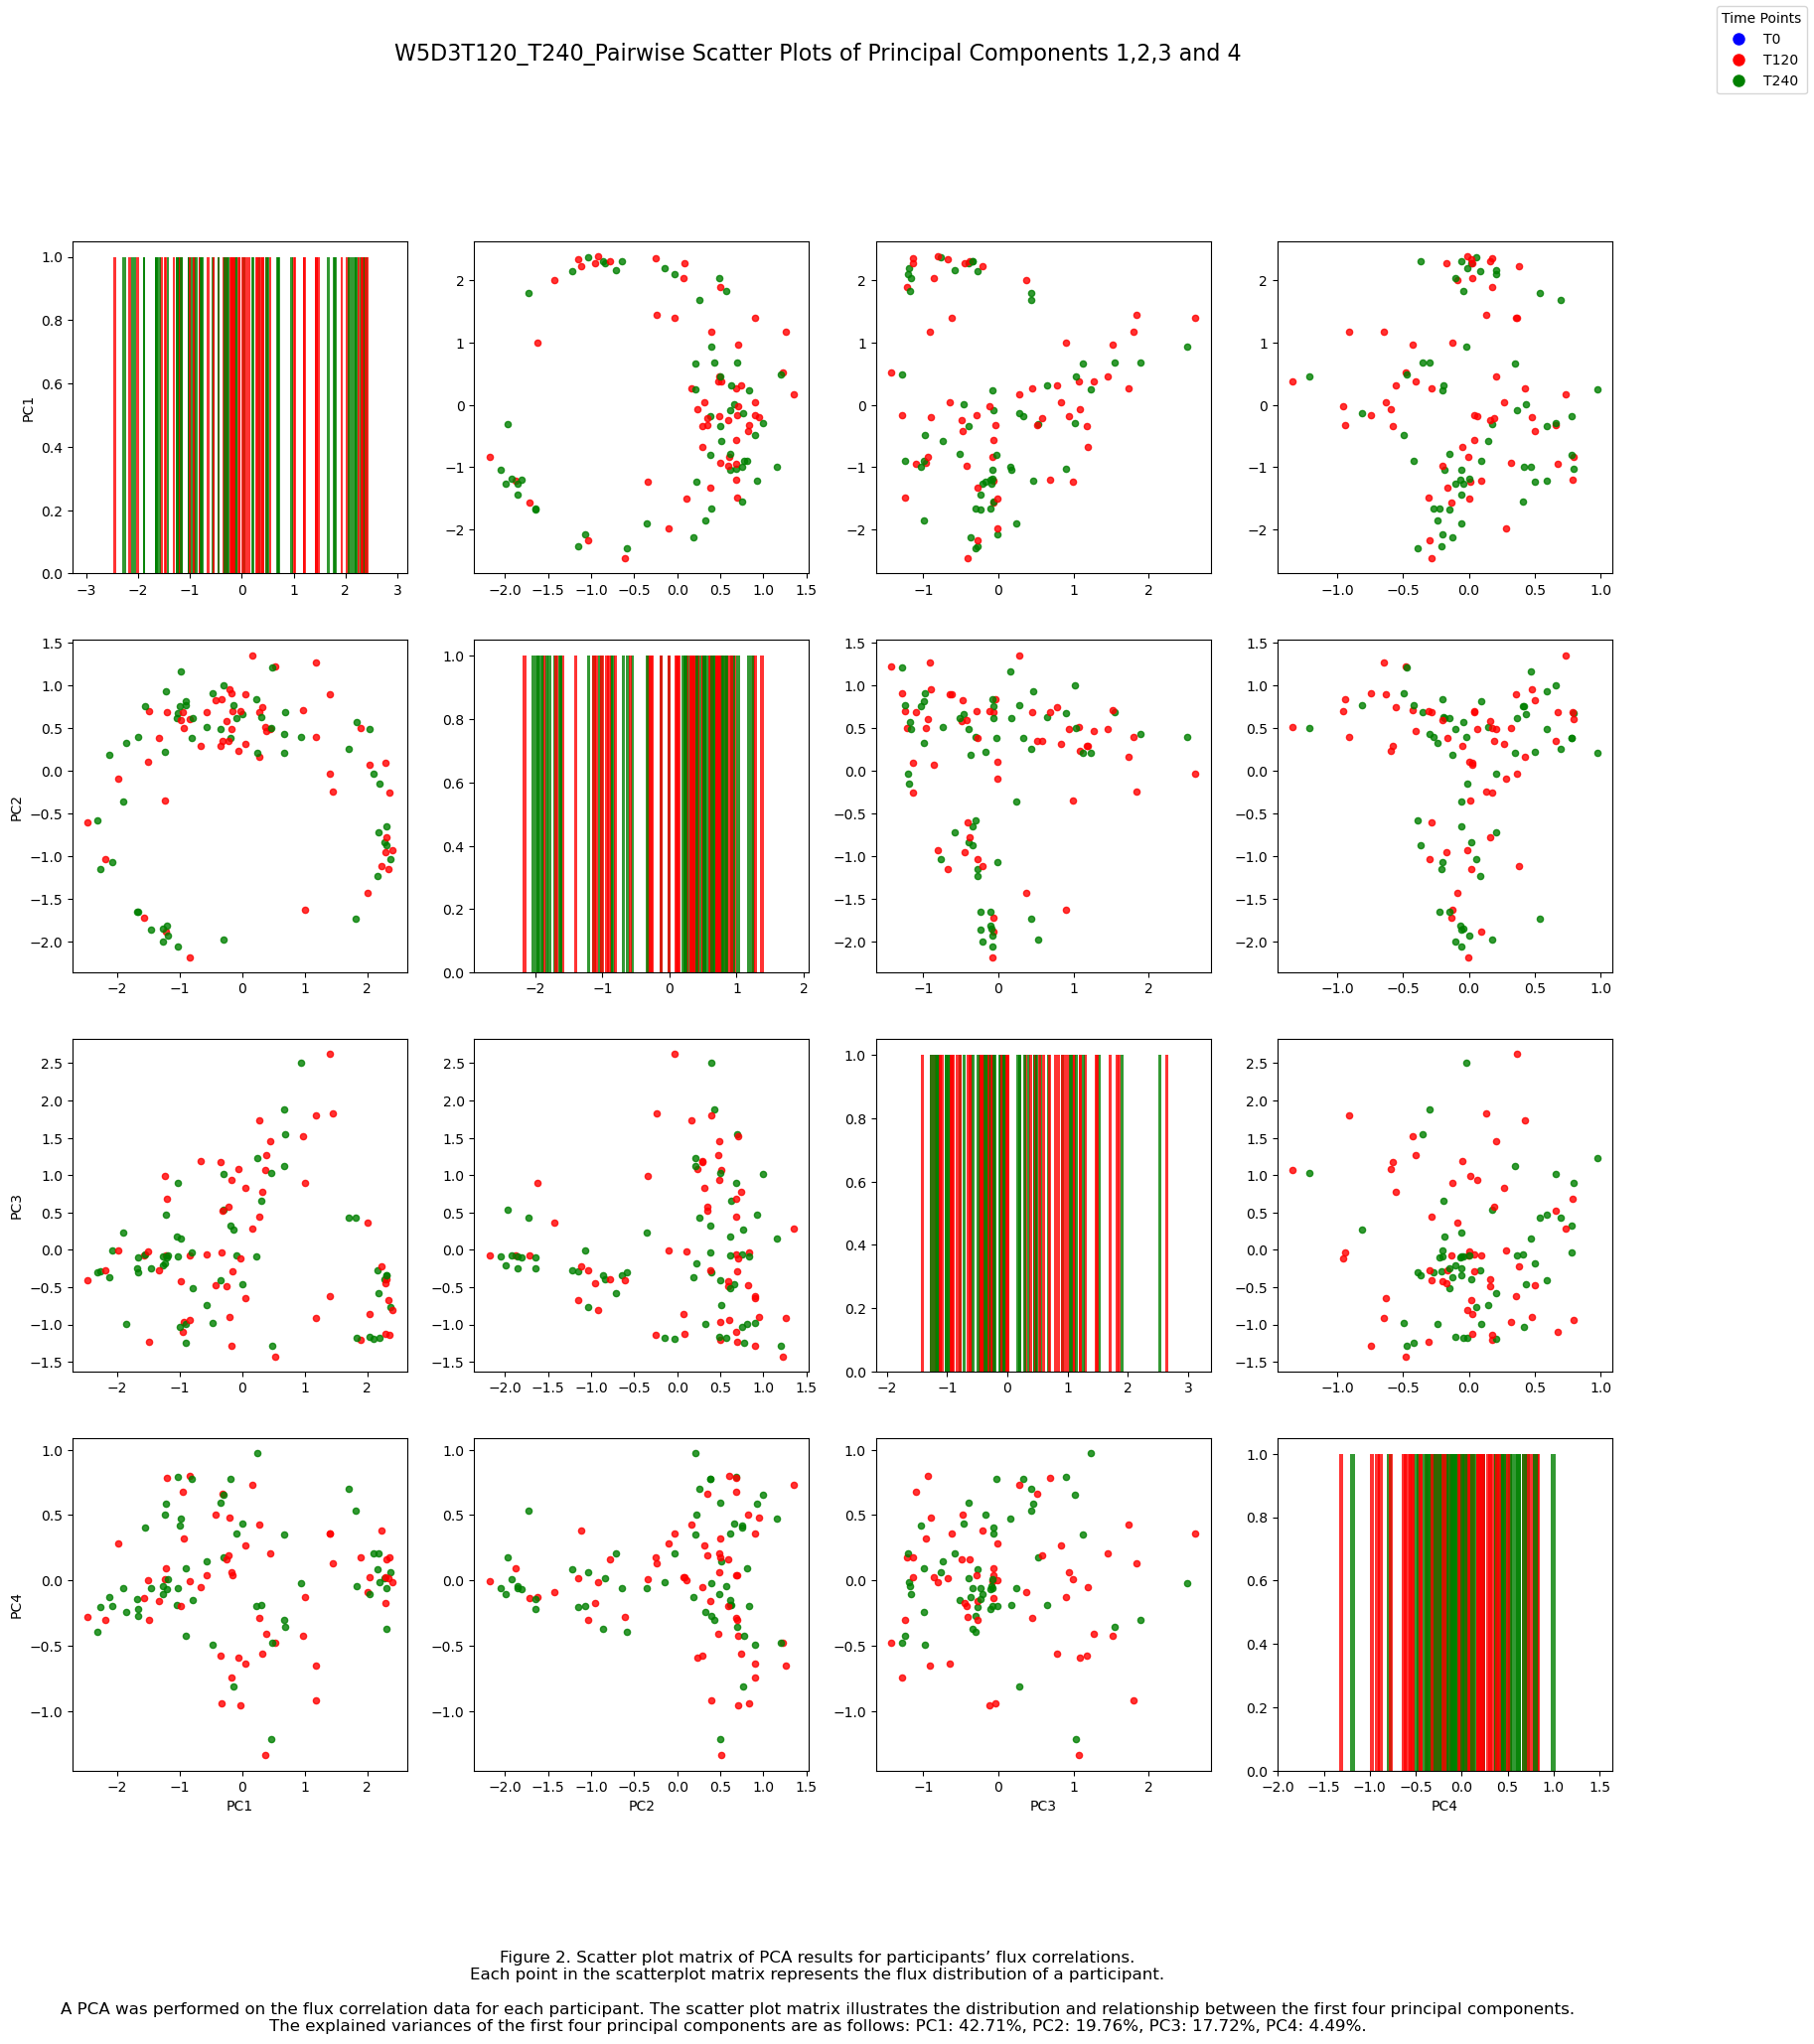

In [4]:
# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T120_T240'
flxID= 'pw_flx2_7.csv'
# %% Load the context-specific models
directory_path = f'/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/{file_ID}'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx_df)
pw_flx
# Save pw_flx1 as a CSV file
pw_flx.to_csv(f'{flxID}', index=False)

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv(f'{flxID}')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]


# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID}_PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}_fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID}_Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}_fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()
